# PTBXL ECG Anomaly Detection with Counterfactual Explanations

3 layer explainable AI pipeline for ECG anomaly detection:

1. Detection layer - 1D CNN for anomaly detection
2. Counterfactual layer - uses nearest neighbour approach to generate counterfactual explanations
3. Explanation layer: LLM (open ai) powered clinical translations of the counterfactual explanations

## Dataset
PTBXL dataset - a large publicly available electrocardiography dataset:
- 21837 clinical 12 lead ECG recordings
- 10 second recordings at 100 Hz (1000 samples)
- Annotated with diagnostic statements

## Setup

In [6]:
%pip install wfdb numpy pandas scipy scikit-learn matplotlib seaborn openai tqdm

import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import time
import os
import ast
import wfdb
from scipy import signal
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cdist, euclidean
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Dict, List, Tuple, Optional, Union, Literal
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from tqdm import tqdm
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

print("Dependencies loaded successfully")

Note: you may need to restart the kernel to use updated packages.
Dependencies loaded successfully


## Pipeline Configuration

In [7]:
from dataclasses import dataclass, field

@dataclass
class PipelineConfig:
    # Dataset selection
    dataset: Literal['ptbxl'] = 'ptbxl'
    
    # Data parameters
    sampling_rate: int = 100 # PTBXL uses 100Hz
    signal_length: int = 1000 # PTBXL has 10 second recordings at 100Hz = 1000 samples
    n_leads: int = 12 # PTBXL has 12 leads
    data_dir: str = './data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
    
    # Preprocessing
    lowcut: float = 0.5       # high-pass filter cutoff (removes baseline wander)
    highcut: float = 40.0     # low-pass filter cutoff (removes muscle noise)
    filter_order: int = 4
    
    # Anomaly detection
    contamination: float = 0.1 # expected proportion of anomalies
    if_n_estimators: int = 100  # Isolation Forest trees
    svm_kernel: str = 'rbf' # OCSVM kernel
    svm_nu: float = 0.1 # OCSVM nu parameter
    svm_gamma: str = 'scale' # OCSM gamma

    # CNN
    cnn_epochs: int = 10
    cnn_batch_size: int = 64
    cnn_lr: float = 1e-3
    cnn_weight_decay: float = 1e-4
    cnn_val_split: float = 0.2
    cnn_target_recall: float = 0.85
    
    # Counterfactual
    n_neighbors: int = 5 # 5 nearest neighbours
    distance_metric: str = 'euclidean'
    cf_max_sparsity: int = 10 # Max number of feature changes allowed
    cf_search_k: int = 50 # Number of neighbors to search for counterfactuals
    
    # LLM
    llm_backend: str = 'openai'
    llm_model: str = 'gpt-4o-mini'
    llm_temperature: float = 0.2 # lower for more consistent outputs
    llm_max_tokens: int = 512
    llm_api_key_env: str = 'OPENAI_API_KEY'
    
    # Output
    output_dir: str = './outputs'
    
    @property
    def is_multilead(self) -> bool:
        return self.n_leads > 1
    
    def __repr__(self) -> str:
        return (
            f"PipelineConfig(\n"
            f"  dataset='{self.dataset}',\n"
            f"  sampling_rate={self.sampling_rate}Hz,\n"
            f"  signal_length={self.signal_length},\n"
            f"  n_leads={self.n_leads},\n"
            f"  data_dir='{self.data_dir}'\n"
            f")"
        )

config = PipelineConfig(dataset='ptbxl')

print(f"Pipeline configured with: {config}")

Pipeline configured with: PipelineConfig(
  dataset='ptbxl',
  sampling_rate=100Hz,
  signal_length=1000,
  n_leads=12,
  data_dir='./data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
)


## Data Loading & Preprocessing

In [8]:
class PTBXLDataLoader:
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.metadata = None
        self.scp_statements = None

    def _parse_scp_codes(self, scp_codes_str: str) -> dict:
        try:
            if pd.isna(scp_codes_str):
                return {}
            return ast.literal_eval(scp_codes_str)
        except:
            return {}
    
    def _load_scp_statements(self, data_path: Path) -> pd.DataFrame:
        scp_df = pd.read_csv(data_path / 'scp_statements.csv', index_col=0)
        return scp_df
    
    def _aggregate_diagnostic_codes(self, scp_codes: dict) -> dict:
        if self.scp_statements is None:
            return {}
        
        superclass_scores = {}
        for code, likelihood in scp_codes.items():
            if code in self.scp_statements.index:
                superclass = self.scp_statements.loc[code, 'diagnostic_class']
                if pd.notna(superclass):
                    if superclass not in superclass_scores:
                        superclass_scores[superclass] = likelihood
                    else: 
                        superclass_scores[superclass] = max(superclass_scores[superclass], likelihood)
        return superclass_scores
        
    def _is_normal(self, scp_codes: dict) -> bool:
        if not scp_codes:
            return False
        
        # Check NORM is present with sufficient likelihood (how certain the annotation of this ecg is)
        if 'NORM' not in scp_codes or scp_codes.get('NORM', 0) < 50:
            return False
        
        # get diagnostic superclasses
        superclasses = self._aggregate_diagnostic_codes(scp_codes)

        high_conf = {k: v for k, v in superclasses.items() if v >= 50}

        return set(high_conf.keys()) == {'NORM'}

    def _is_anomaly(self, scp_codes: dict) -> bool:
        if not scp_codes:
            return False

        superclasses = self._aggregate_diagnostic_codes(scp_codes)

        # check for non-NORM codes with sufficient likelihood
        for cls, likelihood in superclasses.items():
            if cls != 'NORM' and likelihood >= 50:
                return True
        return False
    
    def load_ptbxl(self, data_path: str = None, test_fold: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        if data_path is None:
            data_path = self.config.data_dir

        data_path = Path(data_path)

        # load scp statements
        print(f"Loading PTBXL SCP statements from {data_path}....")
        self.scp_statements = self._load_scp_statements(data_path)  
        print(f"Loaded {len(self.scp_statements)} SCP code definitions")

        # load metadata
        print(f"Loading PTBXL metadata from {data_path}....")
        self.metadata = pd.read_csv(data_path / 'ptbxl_database.csv', index_col='ecg_id')

        # parse scp_codes
        print("Parsing diagnostic codes....")
        self.metadata['scp_codes_dict'] = self.metadata['scp_codes'].apply(self._parse_scp_codes)

        # identify strict normal vs anomaly
        self.metadata['is_normal'] = self.metadata['scp_codes_dict'].apply(self._is_normal)
        self.metadata['is_anomaly'] = self.metadata['scp_codes_dict'].apply(self._is_anomaly)

        # filter to keep only strict normal OR a clear anomaly so its not ambiguous
        valid_mask = self.metadata['is_normal'] | self.metadata['is_anomaly']
        filtered_metadata = self.metadata[valid_mask].copy()

        print(f"\nFiltering results:")
        print(f"Total records: {len(self.metadata)}")
        print(f"Normal: {self.metadata['is_normal'].sum()}")
        print(f"Anomaly: {self.metadata['is_anomaly'].sum()}")
        print(f"Valid records (used): {len(filtered_metadata)}")

        # 0 = normal, 1 = anomaly
        filtered_metadata['label'] = (~filtered_metadata['is_normal']).astype(int)

        # split by strat_fold (ptbxl recommended)
        train_mask = filtered_metadata['strat_fold'] != test_fold
        test_mask = filtered_metadata['strat_fold'] == test_fold
        train_metadata = filtered_metadata[train_mask]
        test_metadata = filtered_metadata[test_mask]

        print(f"\nSplit by fold {test_fold}:")
        print(f"Training records: {len(train_metadata)}")
        print(f"Test records: {len(test_metadata)}")

        # Load ECG signals
        print("\nLoading ECG signals...")

        X_train = self._load_signals(train_metadata, data_path)
        X_test = self._load_signals(test_metadata, data_path)
        y_train = train_metadata['label'].values
        y_test = test_metadata['label'].values

        print(f"\nPTB-XL loaded:")
        print(f"Training: {X_train.shape[0]} samples, {X_train.shape[1]} timesteps, {X_train.shape[2]} leads")
        print(f"Test: {X_test.shape[0]} samples")
        print(f"Normal (train): {np.sum(y_train == 0)}, Anomaly (train): {np.sum(y_train == 1)}")
        print(f"Normal (test): {np.sum(y_test == 0)}, Anomaly (test): {np.sum(y_test == 1)}")

        return X_train, X_test, y_train, y_test
    
    # loads ecg signals and standardise them to the same length 
    def _load_signals(self, metadata: pd.DataFrame, data_path: Path) -> np.ndarray:
        signals = []

        if self.config.sampling_rate == 100:
            filename_col = 'filename_lr' # low resolution 100hz
        else: 
            filename_col = 'filename_hr' # high resolution 500hz
        
        for idx, row in tqdm(metadata.iterrows(), total = len(metadata), desc="Loading signals"):
            try:
                filepath = data_path / row [filename_col]
                record = wfdb.rdrecord(str(filepath))
                sig = record.p_signal # shape: (samples, leads)

                if sig.shape[0] >= self.config.signal_length:
                    sig = sig[:self.config.signal_length, :]
                else:
                    pad_length = self.config.signal_length - sig.shape[0]
                    sig = np.pad(sig, ((0, pad_length), (0, 0)), mode ='edge') # pad by repeating the final value
                
                signals.append(sig)
            except Exception as e:
                print(f"Error loading {row[filename_col]}: {e}")

        return np.array(signals)

In [9]:
# Bandpass filtering, normalisation and quality checks.
# preprocessor for single and multi-lead ECG data
# 2d array: (samples, timesteps), or 3d array: (samples, timesteps, leads)
# 2d is single lead, 3d is multi-lead

class ECGPreprocessor:
    def __init__(self, config: PipelineConfig):
        self.config = config
        # self.scaler = StandardScaler()
    
    # Butterworth bandpass filter to remove baseline wander and high frequency noise
    def bandpass_filter(self, X: np.ndarray) -> np.ndarray:
        # High pass (0.5 Hz): removes baseline wander from respiration
        # Low-pass (40 Hz): removes muscle noise and powerline interference

        nyquist = self.config.sampling_rate / 2
        low = self.config.lowcut / nyquist
        high = self.config.highcut / nyquist
        
        if high >= 1.0:
            high = 0.99
        if low <= 0.0:
            low = 0.01
            
        b, a = signal.butter(self.config.filter_order, [low, high], btype='band')
        
        if X.ndim == 3: # multi-lead (samples, timesteps, leads)
            filtered = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    filtered[i, :, j] = signal.filtfilt(b, a, X[i, :, j])
            return filtered
        else:
            raise ValueError(f"Unexpected array dimensions for bandpass filtering")
    
    # z score normalisation
    def normalize(self, X: np.ndarray) -> np.ndarray:
        if X.ndim == 3: # multi-lead (samples, timesteps, leads)
            normalized = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    sig = X[i, :, j]
                    normalized[i, :, j] = (sig - np.mean(sig)) / (np.std(sig) + 1e-8)
            return normalized
        else:
            raise ValueError(f"Unexpected array dimensions for normalization: {X.ndim}")
    
    def preprocess(self, X: np.ndarray, apply_filter: bool = True) -> np.ndarray:
        X_processed = X.copy()

        if np.isnan(X_processed).any():
            print(f"Warning: Found {np.isnan(X_processed).sum()} NaN values in the data before preprocessing, replacing with 0")
            X_processed = np.nan_to_num(X_processed, nan=0.0)
        
        if apply_filter:
            X_processed = self.bandpass_filter(X_processed)
        
        X_processed = self.normalize(X_processed)

        if np.isnan(X_processed).any():
            X_processed = np.nan_to_num(X_processed, nan=0.0)
        
        return X_processed

In [10]:
# Load PTB-XL data
loader = PTBXLDataLoader(config) 
preprocessor = ECGPreprocessor(config)

X_train_raw, X_test_raw, y_train, y_test = loader.load_ptbxl(
    data_path=config.data_dir,
    test_fold=10
)

# preprocess
print("\nPreprocessing data...")
X_train = preprocessor.preprocess(X_train_raw)
X_test = preprocessor.preprocess(X_test_raw)

# ptbxl results
print(f"\nTrain set: {X_train.shape[0]} samples, {X_train.shape[1]} timesteps, {X_train.shape[2]} leads")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Anomaly ratio (train): {np.mean(y_train):.2%}")
print(f"Anomaly ratio (test): {np.mean(y_test):.2%}")

Loading PTBXL SCP statements from data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3....
Loaded 71 SCP code definitions
Loading PTBXL metadata from data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3....
Parsing diagnostic codes....

Filtering results:
Total records: 21799
Normal: 9038
Anomaly: 11335
Valid records (used): 20373

Split by fold 10:
Training records: 18323
Test records: 2050

Loading ECG signals...


Loading signals: 100%|██████████| 2050/2050 [00:04<00:00, 425.59it/s]



PTB-XL loaded:
Training: 18323 samples, 1000 timesteps, 12 leads
Test: 2050 samples
Normal (train): 8129, Anomaly (train): 10194
Normal (test): 909, Anomaly (test): 1141

Preprocessing data...

Train set: 18323 samples, 1000 timesteps, 12 leads
Test set: 2050 samples
Anomaly ratio (train): 55.63%
Anomaly ratio (test): 55.66%


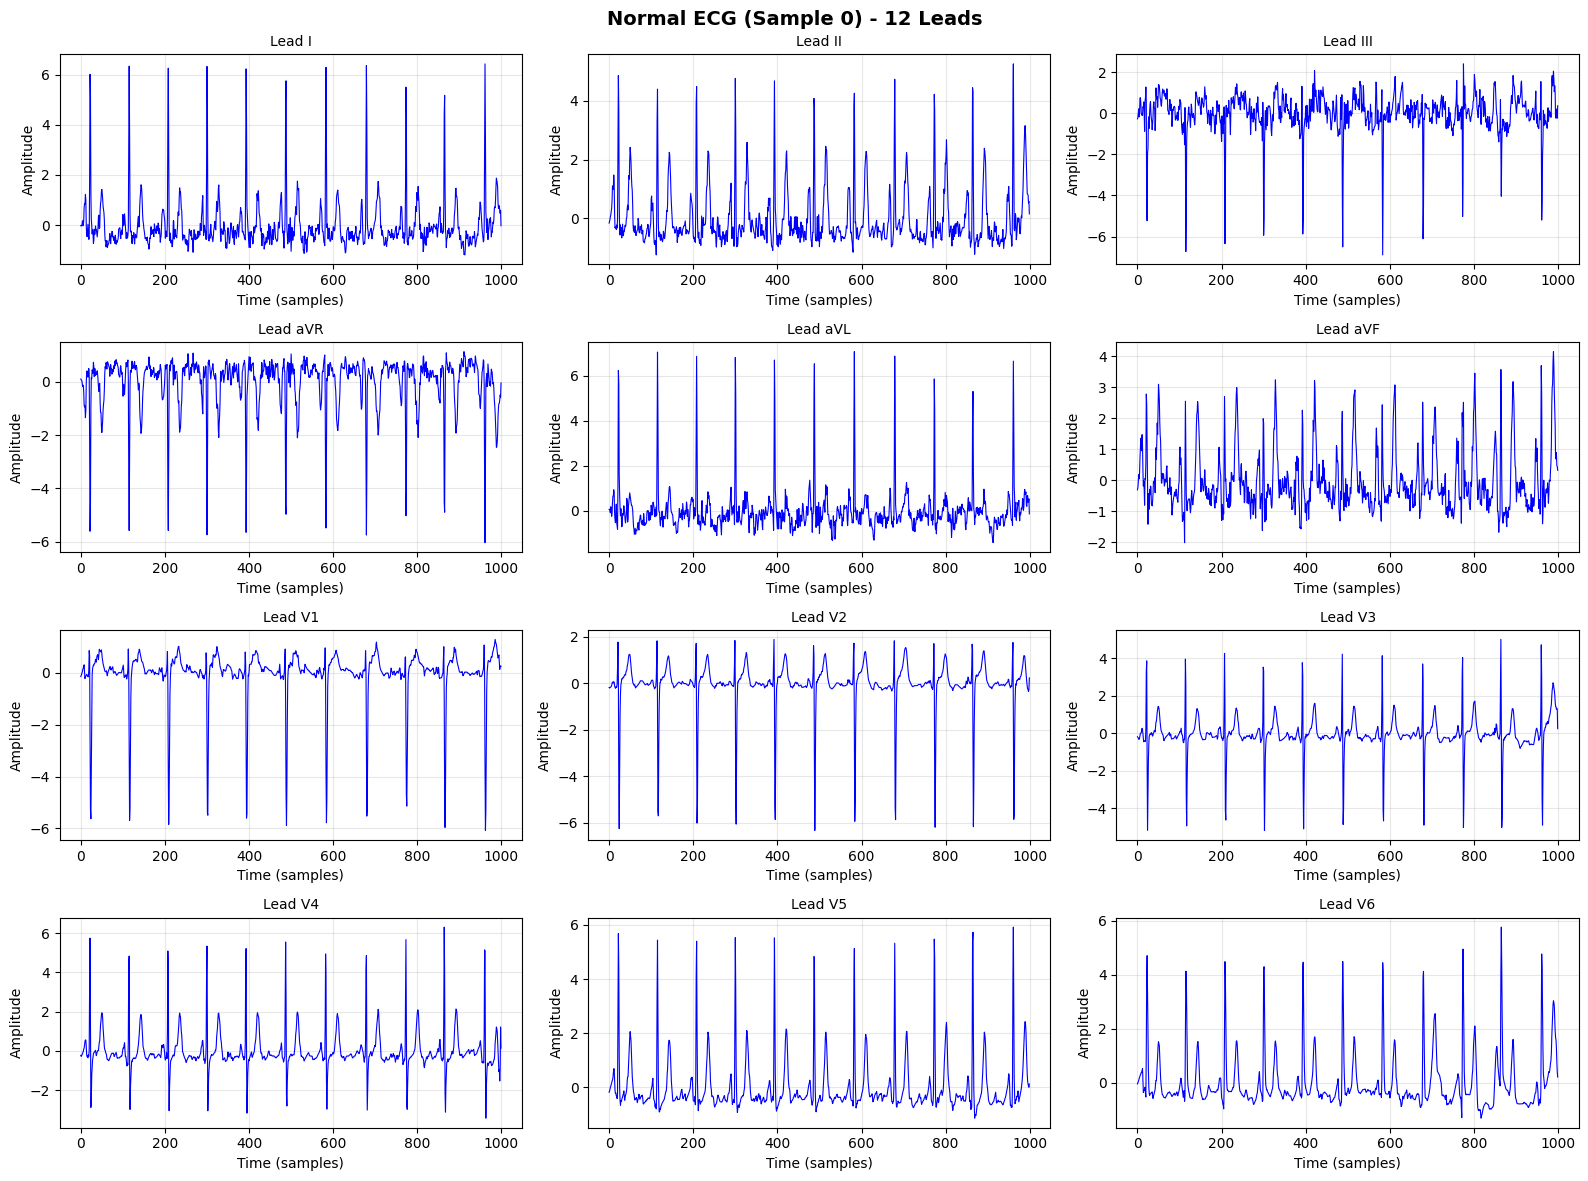

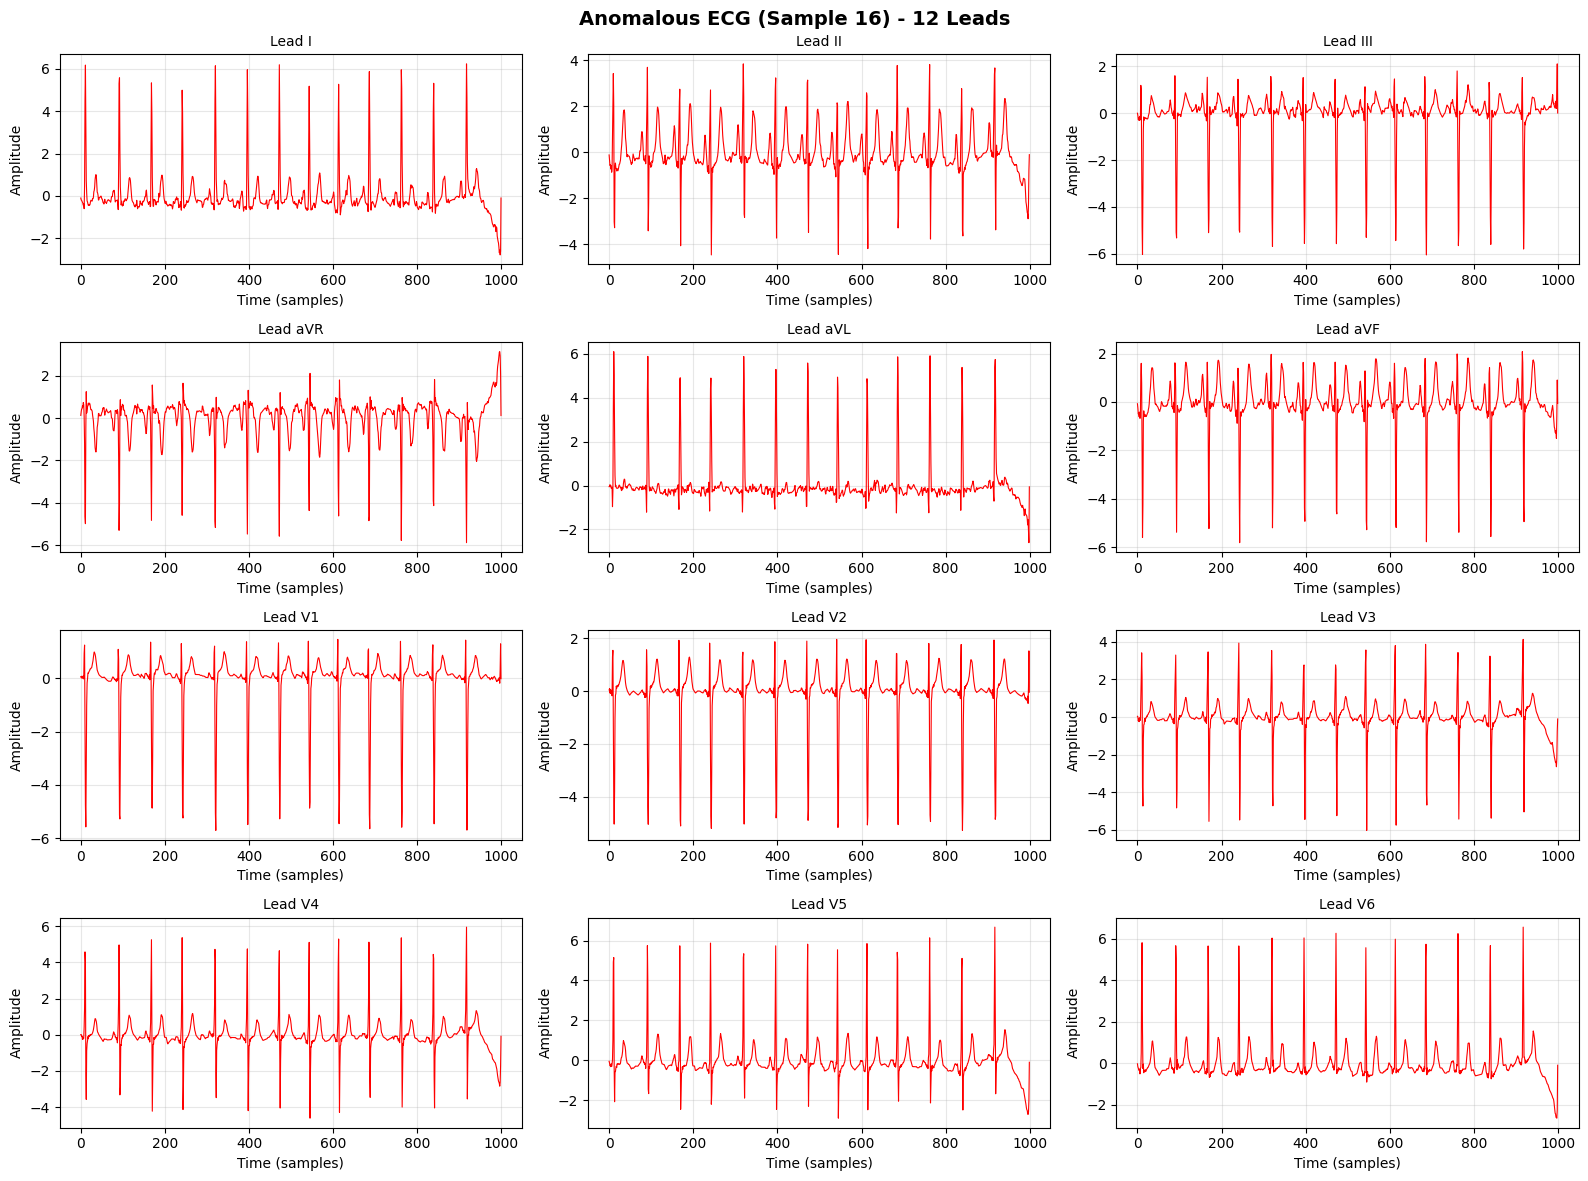

In [11]:
# visualise Sample ECGs (ptbxl)
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()

# 1 normal sample
normal_idx = np.where(y_train == 0)[0][0]
sample = X_train[normal_idx]

for lead_idx, ax in enumerate(axes):
    ax.plot(sample[:, lead_idx], 'b-', linewidth=0.8)
    ax.set_title(f'Lead {LEAD_NAMES[lead_idx]}', fontsize=10)
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Normal ECG (Sample {normal_idx}) - 12 Leads', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ecg_normal_12lead.png', dpi=150, bbox_inches='tight')
plt.show()

# 1 anomaly sample
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()

anomaly_idx = np.where(y_train == 1)[0][0]
sample = X_train[anomaly_idx]

for lead_idx, ax in enumerate(axes):
    ax.plot(sample[:, lead_idx], 'r-', linewidth=0.8)
    ax.set_title(f'Lead {LEAD_NAMES[lead_idx]}', fontsize=10)
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Anomalous ECG (Sample {anomaly_idx}) - 12 Leads', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ecg_anomaly_12lead.png', dpi=150, bbox_inches='tight')
plt.show()

## Feature Extraction

Extract clinically relevant features from the ECGs
- Statistical features
- Temporal/morphological features
- Frequency domain features

In [12]:
# feature extraction from single and multi-lead ECG signals
class ECGFeatureExtractor:    
    LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.feature_names = []
        self.is_multilead = config.n_leads > 1
        # Minimum RR interval: ~200ms (300 BPM max realistic HR)
        self.min_peak_distance = int(0.2 * config.sampling_rate)
    
    # Statistical features
    def extract_statistical_features(self, x: np.ndarray) -> Dict[str, float]:
        
        return {
            'mean': np.mean(x),
            'std': np.std(x),
            'var': np.var(x),
            'min': np.min(x),
            'max': np.max(x),
            'range': np.ptp(x),  # peak to peak cleaner than max - min
            'median': np.median(x),
            'skewness': skew(x),
            'kurtosis': kurtosis(x),
            'rms': np.sqrt(np.mean(x**2)),
            'zero_crossings': np.sum(np.diff(np.signbit(x)))
        }
    
    # Temporal/morphological features
    def extract_temporal_features(self, x: np.ndarray) -> Dict[str, float]:
        threshold = np.mean(x) + 0.5 * np.std(x)
        peaks, _ = signal.find_peaks(x, height=threshold, distance=self.min_peak_distance)
        
        features = {}
        
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks)
            rr_mean = np.mean(rr_intervals)
            features['rr_mean'] = rr_mean
            features['rr_std'] = np.std(rr_intervals)
            features['rr_min'] = np.min(rr_intervals)
            features['rr_max'] = np.max(rr_intervals)
            features['hr_estimate'] = 60 * self.config.sampling_rate / rr_mean if rr_mean > 0 else 0
            features['hrv'] = np.std(rr_intervals) / (rr_mean + 1e-8)
        else:
            features['rr_mean'] = 0
            features['rr_std'] = 0
            features['rr_min'] = 0
            features['rr_max'] = 0
            features['hr_estimate'] = 0
            features['hrv'] = 0
        
        features['n_peaks'] = len(peaks)
        
        if len(peaks) > 0:
            peak_heights = x[peaks]
            features['peak_height_mean'] = np.mean(peak_heights)
            features['peak_height_std'] = np.std(peak_heights) if len(peaks) > 1 else 0
        else:
            features['peak_height_mean'] = 0
            features['peak_height_std'] = 0
        
        return features
    
    # Frequency domain features using fft
    def extract_frequency_features(self, x: np.ndarray) -> Dict[str, float]:
        fft_vals = np.abs(np.fft.rfft(x))
        fft_freq = np.fft.rfftfreq(len(x), d=1/self.config.sampling_rate)
        
        total_power = np.sum(fft_vals**2) + 1e-8
        
        # HRV frequency bands
        vlf_mask = (fft_freq >= 0) & (fft_freq < 0.04)
        lf_mask = (fft_freq >= 0.04) & (fft_freq < 0.15)
        hf_mask = (fft_freq >= 0.15) & (fft_freq < 0.4)
        
        vlf_power = np.sum(fft_vals[vlf_mask]**2) / total_power if vlf_mask.any() else 0
        lf_power = np.sum(fft_vals[lf_mask]**2) / total_power if lf_mask.any() else 0
        hf_power = np.sum(fft_vals[hf_mask]**2) / total_power if hf_mask.any() else 0
        
        # Spectral entropy
        psd_norm = fft_vals / (np.sum(fft_vals) + 1e-8)
        spectral_entropy = -np.sum(psd_norm * np.log(psd_norm + 1e-8))
        
        return {
            'total_power': total_power,
            'vlf_power': vlf_power,
            'lf_power': lf_power,
            'hf_power': hf_power,
            'lf_hf_ratio': lf_power / (hf_power + 1e-8),
            'dominant_freq': fft_freq[np.argmax(fft_vals)] if len(fft_vals) > 0 else 0,
            'spectral_entropy': spectral_entropy
        }
    
    # extract features from a single lead
    def _extract_single_lead_features(self, x: np.ndarray, prefix: str = '') -> Dict[str, float]:
        features = {}
        
        for feat_dict in [
            self.extract_statistical_features(x),
            self.extract_temporal_features(x),
            self.extract_frequency_features(x)
        ]:
            for k, v in feat_dict.items():
                key = f'{prefix}_{k}' if prefix else k
                features[key] = v
        
        return features
    
    # extract features capturing relationships between leads
    def extract_inter_lead_features(self, X: np.ndarray) -> Dict[str, float]:
        features = {}
        n_leads = X.shape[1]
        
        # Key lead pair correlations
        lead_pairs = [
            (0, 1),   # I vs II
            (0, 5),   # I vs aVF
            (6, 7),   # V1 vs V2
            (7, 8),   # V2 vs V3
            (9, 10),  # V4 vs V5
            (10, 11), # V5 vs V6
        ]
        
        for i, j in lead_pairs:
            if i < n_leads and j < n_leads:
                corr = np.corrcoef(X[:, i], X[:, j])[0, 1]
                name_i = self.LEAD_NAMES[i] if i < len(self.LEAD_NAMES) else f'L{i}'
                name_j = self.LEAD_NAMES[j] if j < len(self.LEAD_NAMES) else f'L{j}'
                features[f'corr_{name_i}_{name_j}'] = corr if not np.isnan(corr) else 0
        
        # QRS axis approximation (needs leads I and aVF)
        if n_leads >= 6:
            lead_I_max = np.max(X[:, 0])
            lead_aVF_max = np.max(X[:, 5])
            features['qrs_axis_approx'] = np.degrees(np.arctan2(lead_aVF_max, lead_I_max))
        
        # R wave progression across precordial leads (V1-V6)
        if n_leads >= 12:
            v_leads_max = [np.max(X[:, i]) for i in range(6, 12)]
            features['r_wave_progression'] = np.mean(np.diff(v_leads_max))
            features['r_wave_v1'] = v_leads_max[0]
            features['r_wave_v6'] = v_leads_max[5]
        
        # Global amplitude variability
        lead_stds = [np.std(X[:, i]) for i in range(n_leads)]
        features['inter_lead_std_mean'] = np.mean(lead_stds)
        features['inter_lead_std_var'] = np.var(lead_stds)
        
        return features
    
    # extract all features from single or multi-lead ECG
    def extract_all_features(self, X: np.ndarray) -> np.ndarray:
        features = {}
        
        if X.ndim == 2:
            # Multi-lead: (timesteps, leads)
            for lead_idx in range(X.shape[1]):
                prefix = self.LEAD_NAMES[lead_idx] if lead_idx < len(self.LEAD_NAMES) else f'lead_{lead_idx}'
                features.update(self._extract_single_lead_features(X[:, lead_idx], prefix))
            
            features.update(self.extract_inter_lead_features(X))
        
        else:
            raise ValueError(f"Expected 2D array for multi-lead sample, got shape {X.shape}")
        
        # Store feature names on first call
        if not self.feature_names:
            self.feature_names = list(features.keys())
        
        feature_array = np.array(list(features.values()))
        return np.nan_to_num(feature_array, nan=0.0, posinf=0.0, neginf=0.0)
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        if X.ndim  == 3:
            # Multiple multi-lead samples: (samples, timesteps, leads)
            return np.array([self.extract_all_features(x) for x in tqdm(X, desc="Extracting features")])
        
        else:
            raise ValueError(f"Unexpected input dimension: {X.ndim}")

In [13]:
# extract the features
feature_extractor = ECGFeatureExtractor(config)

print("\nExtracting features from training set...")
X_train_features = feature_extractor.transform(X_train)
print("Extracting features from test set...")
X_test_features = feature_extractor.transform(X_test)

print(f"Feature matrix shape: {X_train_features.shape}")
print(f"\nExtracted features ({len(feature_extractor.feature_names)}):")
for i, name in enumerate(feature_extractor.feature_names):
    print(f"  {i+1}. {name}")

# Handle NaN/Inf values before scaling
print("\nChecking for NaN/Inf values in features...")
nan_count_train = np.isnan(X_train_features).sum()
inf_count_train = np.isinf(X_train_features).sum()
print(f"  Train - NaN: {nan_count_train}, Inf: {inf_count_train}")

nan_count_test = np.isnan(X_test_features).sum()
inf_count_test = np.isinf(X_test_features).sum()
print(f"  Test - NaN: {nan_count_test}, Inf: {inf_count_test}")

# SimpleImputer to handle NaNs
imputer = SimpleImputer(strategy='median')
X_train_features = imputer.fit_transform(X_train_features)
X_test_features = imputer.transform(X_test_features)

# Replace remaining inf values
X_train_features = np.nan_to_num(X_train_features, nan=0.0, posinf=0.0, neginf=0.0)
X_test_features = np.nan_to_num(X_test_features, nan=0.0, posinf=0.0, neginf=0.0)


Extracting features from training set...


Extracting features: 100%|██████████| 18323/18323 [03:38<00:00, 83.95it/s]


Extracting features from test set...


Extracting features: 100%|██████████| 2050/2050 [00:22<00:00, 90.74it/s]


Feature matrix shape: (18323, 336)

Extracted features (336):
  1. I_mean
  2. I_std
  3. I_var
  4. I_min
  5. I_max
  6. I_range
  7. I_median
  8. I_skewness
  9. I_kurtosis
  10. I_rms
  11. I_zero_crossings
  12. I_rr_mean
  13. I_rr_std
  14. I_rr_min
  15. I_rr_max
  16. I_hr_estimate
  17. I_hrv
  18. I_n_peaks
  19. I_peak_height_mean
  20. I_peak_height_std
  21. I_total_power
  22. I_vlf_power
  23. I_lf_power
  24. I_hf_power
  25. I_lf_hf_ratio
  26. I_dominant_freq
  27. I_spectral_entropy
  28. II_mean
  29. II_std
  30. II_var
  31. II_min
  32. II_max
  33. II_range
  34. II_median
  35. II_skewness
  36. II_kurtosis
  37. II_rms
  38. II_zero_crossings
  39. II_rr_mean
  40. II_rr_std
  41. II_rr_min
  42. II_rr_max
  43. II_hr_estimate
  44. II_hrv
  45. II_n_peaks
  46. II_peak_height_mean
  47. II_peak_height_std
  48. II_total_power
  49. II_vlf_power
  50. II_lf_power
  51. II_hf_power
  52. II_lf_hf_ratio
  53. II_dominant_freq
  54. II_spectral_entropy
  55. II

In [14]:
# scale the features
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_features)
X_test_scaled = feature_scaler.transform(X_test_features)

# verify no NaN/Inf after scaling
print(f"\nAfter imputation and scaling:")
print(f"  Train NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"  Test NaN count: {np.isnan(X_test_scaled).sum()}")


After imputation and scaling:
  Train NaN count: 0
  Test NaN count: 0


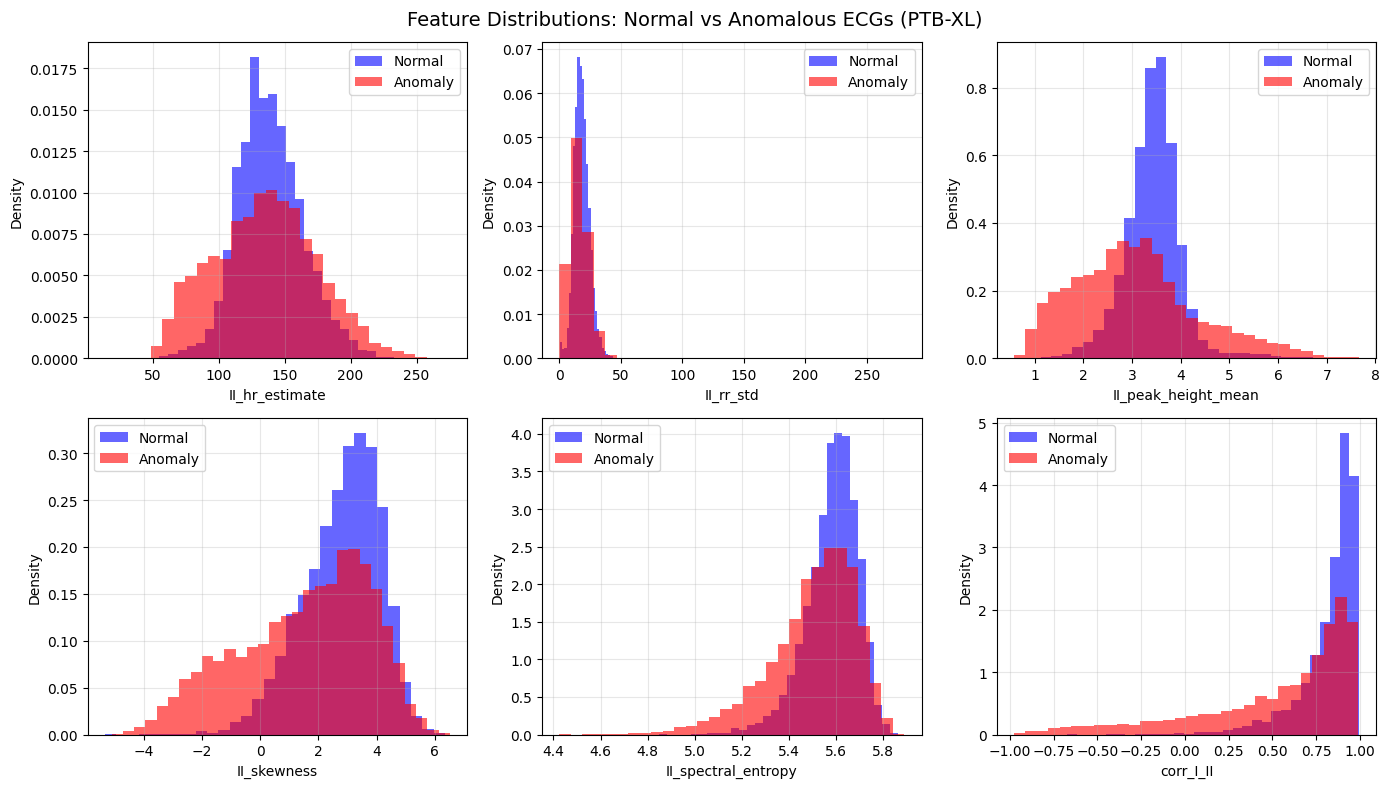

In [15]:
# visualise Feature Distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

key_features = ['II_hr_estimate', 'II_rr_std', 'II_peak_height_mean', 'II_skewness', 'II_spectral_entropy', 'corr_I_II']
for ax, feat_name in zip(axes.flat, key_features):
    if feat_name in feature_extractor.feature_names:
        feat_idx = feature_extractor.feature_names.index(feat_name)
        
        normal_vals = X_train_features[y_train == 0, feat_idx]
        anomaly_vals = X_train_features[y_train == 1, feat_idx]
        
        ax.hist(normal_vals, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
        ax.hist(anomaly_vals, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
        ax.set_xlabel(feat_name)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions: Normal vs Anomalous ECGs (PTB-XL)', fontsize=14)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Anomaly Detection

In [16]:
class AnomalyDetector(ABC):
    
    @abstractmethod
    def fit(self, X: np.ndarray) -> 'AnomalyDetector':
        pass
    
    @abstractmethod
    def predict(self, X: np.ndarray) -> np.ndarray:
        pass
    
    @abstractmethod
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        pass

In [17]:
# Evaluate the detector
def evaluate_detector(detector: AnomalyDetector, X_test: np.ndarray, y_test: np.ndarray, 
                      detector_name: str) -> Dict[str, float]:
    y_pred = detector.predict(X_test)
    scores = detector.decision_function(X_test)
    
    metrics = {
        'AUROC': roc_auc_score(y_test, scores),
        'AUPRC': average_precision_score(y_test, scores),
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0)
    }
    
    print(f"\n{'='*50}")
    print(f"{detector_name} Results:")
    print(f"{'='*50}")
    for name, value in metrics.items():
        print(f"  {name}: {value:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}, TP={cm[1,1]}")
    
    return metrics

In [18]:
# Find threshold that gives target recall while maximising precision
def optimize_threshold_for_recall(y_true: np.ndarray, scores: np.ndarray, min_recall: float = 0.85) -> float:
    precisions, recalls, thresholds = precision_recall_curve(y_true, scores)

    valid_idx = recalls[:-1] >= min_recall
    if not valid_idx.any():
        return thresholds[np.argmax(recalls[:-1])]

    best_idx = np.where(valid_idx)[0][np.argmax(precisions[:-1][valid_idx])]
    return thresholds[best_idx]

In [19]:
# 1D CNN anomaly detection utilities
class ECGDataset(Dataset):
    # Wrap preprocessed ECG signals for PyTorch dataloaders
    def __init__(self, signals: np.ndarray, labels: np.ndarray):
        X = np.array(signals, dtype=np.float32)
        if X.ndim == 3:  # (samples, timesteps, leads)
            X = np.transpose(X, (0, 2, 1))  # -> (samples, leads, timesteps)
        else:
            raise ValueError(f"Unexpected ECG shape {X.shape}")
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]


class SimpleECG1DCNN(nn.Module):
    # Compact 1D CNN for anomaly detection on ECG waveforms
    def __init__(self, n_leads: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(n_leads, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, leads, timesteps)
        return self.net(x).squeeze(-1)


class CNNAnomalyDetector(AnomalyDetector):
    # Supervised 1D CNN anomaly detector using BCE loss
    def __init__(self, config: PipelineConfig):
        self.config = config
        n_leads = config.n_leads if config.n_leads is not None else 1
        self.model = SimpleECG1DCNN(n_leads=n_leads)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.epochs = config.cnn_epochs
        self.batch_size = config.cnn_batch_size
        self.learning_rate = config.cnn_lr
        self.weight_decay = config.cnn_weight_decay
        self.threshold: float = 0.5

    def _prepare_tensor(self, X: np.ndarray) -> torch.Tensor:
        arr = np.array(X, dtype=np.float32)
        if arr.ndim  == 3:
            arr = np.transpose(arr, (0, 2, 1))
        else:
            raise ValueError(f"Unexpected input shape for CNN detector: {arr.shape}")
        return torch.tensor(arr, dtype=torch.float32)

    def _predict_proba(self, X: np.ndarray) -> np.ndarray:
        self.model.eval()
        with torch.no_grad():
            tensor = self._prepare_tensor(X).to(self.device)
            logits = self.model(tensor)
            probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        return probs

    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'CNNAnomalyDetector':
        if y is None:
            raise ValueError("CNNAnomalyDetector requires labels for supervised training.")

        # Stratified split for validation
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X,
            y,
            test_size=self.config.cnn_val_split,
            random_state=RANDOM_STATE,
            stratify=y
        )

        train_ds = ECGDataset(X_train_split, y_train_split)
        val_ds = ECGDataset(X_val_split, y_val_split)
        train_loader = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(val_ds, batch_size=self.batch_size, shuffle=False, drop_last=False)

        pos_count = float(np.sum(y_train_split))
        neg_count = float(len(y_train_split) - pos_count)
        pos_weight = torch.tensor([neg_count / (pos_count + 1e-6)], device=self.device)
        if not torch.isfinite(pos_weight).all():
            pos_weight = torch.tensor([1.0], device=self.device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        best_val_loss = float('inf')
        best_state = None

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                optimizer.zero_grad()
                logits = self.model(batch_x)
                loss = criterion(logits, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * batch_x.size(0)

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x = batch_x.to(self.device)
                    batch_y = batch_y.to(self.device)
                    logits = self.model(batch_x)
                    loss = criterion(logits, batch_y)
                    val_loss += loss.item() * batch_x.size(0)

            train_loss /= len(train_ds)
            val_loss /= len(val_ds)
            print(f"Epoch {epoch+1}/{self.epochs} - train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}

        if best_state:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)

        # Calibrate threshold for desired recall on validation set
        val_scores = self.decision_function(X_val_split)
        self.threshold = optimize_threshold_for_recall(
            y_val_split,
            val_scores,
            min_recall=self.config.cnn_target_recall
        )
        print(f"Calibrated CNN threshold for recall>={self.config.cnn_target_recall:.2f}: {self.threshold:.4f}")
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        scores = self.decision_function(X)
        threshold = self.threshold if self.threshold is not None else 0.5
        return (scores >= threshold).astype(int)

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return self._predict_proba(X)

In [20]:
# Train and evaluate the CNN on preprocessed signals
print("\nTraining 1D CNN anomaly detector...")
cnn_detector = CNNAnomalyDetector(config)
cnn_detector.fit(X_train, y_train)
cnn_metrics = evaluate_detector(cnn_detector, X_test, y_test, "1D CNN")


Training 1D CNN anomaly detector...
Epoch 1/10 - train_loss=0.3175 val_loss=0.3768
Epoch 2/10 - train_loss=0.2772 val_loss=0.3273
Epoch 3/10 - train_loss=0.2707 val_loss=0.2772
Epoch 4/10 - train_loss=0.2641 val_loss=0.2666
Epoch 5/10 - train_loss=0.2507 val_loss=0.2921
Epoch 6/10 - train_loss=0.2517 val_loss=0.2591
Epoch 7/10 - train_loss=0.2468 val_loss=0.3480
Epoch 8/10 - train_loss=0.2420 val_loss=0.2652
Epoch 9/10 - train_loss=0.2447 val_loss=0.2560
Epoch 10/10 - train_loss=0.2410 val_loss=0.2661
Calibrated CNN threshold for recall>=0.85: 0.5251

1D CNN Results:
  AUROC: 0.9419
  AUPRC: 0.9591
  F1: 0.8703
  Precision: 0.9302
  Recall: 0.8177

  Confusion Matrix:
  TN=839, FP=70
  FN=208, TP=933


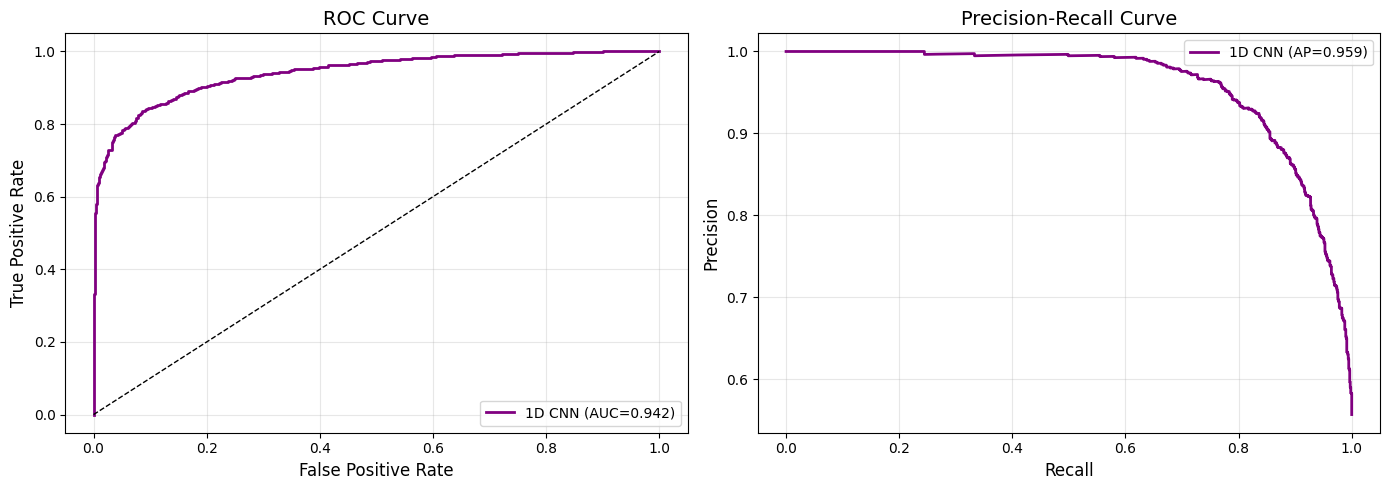

In [21]:
# visualise ROC and PR curves for CNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cnn_scores = cnn_detector.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, cnn_scores)
auc = roc_auc_score(y_test, cnn_scores)
axes[0].plot(fpr, tpr, label=f'1D CNN (AUC={auc:.3f})', color='purple', linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, cnn_scores)
ap = average_precision_score(y_test, cnn_scores)
axes[1].plot(recall, precision, label=f'1D CNN (AP={ap:.3f})', color='purple', linewidth=2)

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('detection_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## Counterfactual Explanations

In [22]:
@dataclass
class CounterfactualExplanation:
    # original information
    original_signal: np.ndarray
    original_features: np.ndarray
    original_prediction: int
    original_score: float
    
    # counterfactual information
    counterfactual_signal: np.ndarray
    counterfactual_features: np.ndarray
    counterfactual_prediction: int
    counterfactual_score: float
    
    # difference analysis
    feature_differences: Dict[str, float] = field(default_factory=dict)
    signal_distance: float = 0.0
    feature_distance: float = 0.0
    
    # quality metrics
    validity: bool = False
    proximity: float = 0.0
    sparsity: int = 0
    
    # Top features that changed
    top_changes: List[Tuple[str, float, float, float]] = field(default_factory=list)

    @property
    def feature_changes(self) -> Dict[str, float]:
        return self.feature_differences

In [23]:
# nearest neighbour counterfactual generator
class NearestNeighbourCounterfactual:    
    def __init__(self, config: PipelineConfig, detector: AnomalyDetector,
                 feature_names: List[str]):
        self.config = config
        self.detector = detector
        self.feature_names = feature_names
        self.nn_model = None
        self.normal_signals = None
        self.normal_features = None
        self.max_sparsity = config.cf_max_sparsity
        self.search_k = config.cf_search_k

    # Fit the nearest neighbour model on normal samples 
    def fit(self, X_signals: np.ndarray, X_features: np.ndarray, y: np.ndarray):
        normal_mask = (y == 0)
        self.normal_signals = X_signals[normal_mask]
        self.normal_features = X_features[normal_mask]
        
        self.nn_model = NearestNeighbors(
            n_neighbors=min(self.search_k, len(self.normal_features)), # dont request more neighbours than samples
            metric=self.config.distance_metric
        )
        self.nn_model.fit(self.normal_features)
        
        print(f"Counterfactual generator fitted on {len(self.normal_signals)} normal samples")

    # Generate cfe for a single sample
    def generate(self, signal: np.ndarray, features: np.ndarray) -> CounterfactualExplanation:
        signal_batch = signal[np.newaxis, ...] if signal.ndim >= 2 else signal.reshape(1, -1)
        original_pred = self.detector.predict(signal_batch)[0]
        original_score = self.detector.decision_function(signal_batch)[0]
        
        distances, indices = self.nn_model.kneighbors(features.reshape(1, -1))
        
        std_threshold = 1.0
        cf_idx = indices[0, 0]
        for candidate_idx in indices[0]:
            candidate_features = self.normal_features[candidate_idx]
            diffs = candidate_features - features
            sparsity = int(np.sum(np.abs(diffs) > std_threshold))
            if sparsity <= self.max_sparsity:
                cf_idx = candidate_idx
                break
        cf_signal = self.normal_signals[cf_idx]
        cf_features = self.normal_features[cf_idx]
        
        cf_pred = self.detector.predict(cf_signal[np.newaxis, ...])[0]
        cf_score = self.detector.decision_function(cf_signal[np.newaxis, ...])[0]
        
        feature_diffs = {}
        for i, name in enumerate(self.feature_names):
            feature_diffs[name] = cf_features[i] - features[i]
        
        signal_dist = np.sqrt(np.mean((signal.flatten() - cf_signal.flatten())**2))
        feature_dist = distances[0, 0]
        
        validity = (original_pred == 1) and (cf_pred == 0)
        
        sparsity = sum(1 for diff in feature_diffs.values() if abs(diff) > std_threshold)
        
        sorted_changes = sorted(
            [(name, features[i], cf_features[i], diff) 
             for i, (name, diff) in enumerate(feature_diffs.items())],
            key=lambda x: abs(x[3]),
            reverse=True
        )
        
        return CounterfactualExplanation(
            original_signal=signal,
            original_features=features,
            original_prediction=original_pred,
            original_score=original_score,
            counterfactual_signal=cf_signal,
            counterfactual_features=cf_features,
            counterfactual_prediction=cf_pred,
            counterfactual_score=cf_score,
            feature_differences=feature_diffs,
            signal_distance=signal_dist,
            feature_distance=feature_dist,
            validity=validity,
            proximity=feature_dist,
            sparsity=sparsity,
            top_changes=sorted_changes[:10]
        )
    
    # generate cfe for multiple samples
    def generate_batch(self, signals: np.ndarray, features: np.ndarray) -> List[CounterfactualExplanation]:
        return [self.generate(s, f) for s, f in tqdm(zip(signals, features), total=len(signals))]

In [24]:
# visualize counterfactual for 12 lead ECG (PTBXL)
def visualize_counterfactual_12lead(cf: CounterfactualExplanation, title: str = ""):
    fig = plt.figure(figsize=(20, 16))
    
    # Plot leads comparison (2x6 grid for all 12 leads)
    for lead_idx in range(12):
        ax = fig.add_subplot(4, 6, lead_idx + 1)
        ax.plot(cf.original_signal[:, lead_idx], 'r-', label='Original', linewidth=1, alpha=0.7)
        ax.plot(cf.counterfactual_signal[:, lead_idx], 'b-', label='CF', linewidth=1, alpha=0.7)
        ax.set_title(f'{LEAD_NAMES[lead_idx]}', fontsize=10)
        ax.set_xlabel('Time')
        ax.grid(True, alpha=0.3)
        if lead_idx == 0:
            ax.legend(fontsize=8)
    
    # Top feature changes
    ax_feat = fig.add_subplot(4, 2, 5)
    top_n = min(8, len(cf.top_changes))
    names = [c[0][:15] for c in cf.top_changes[:top_n]]  # Truncate the long names
    orig_vals = [c[1] for c in cf.top_changes[:top_n]]
    cf_vals = [c[2] for c in cf.top_changes[:top_n]]
    
    x = np.arange(top_n)
    width = 0.35
    ax_feat.bar(x - width/2, orig_vals, width, label='Original', color='red', alpha=0.7)
    ax_feat.bar(x + width/2, cf_vals, width, label='Counterfactual', color='blue', alpha=0.7)
    ax_feat.set_xticks(x)
    ax_feat.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax_feat.set_ylabel('Feature Value (scaled)')
    ax_feat.set_title('Top Feature Changes')
    ax_feat.legend()
    ax_feat.grid(True, alpha=0.3, axis='y')
    
    # Quality metrics
    ax_text = fig.add_subplot(4, 2, 6)
    ax_text.axis('off')
    
    metrics_text = f"""
    COUNTERFACTUAL QUALITY METRICS
    {'='*40}
    
    Validity: {'✓ VALID' if cf.validity else '✗ INVALID'}
    
    Proximity: {cf.proximity:.4f}
    
    Sparsity: {cf.sparsity} features changed
    
    Original Score: {cf.original_score:.4f}
    Counterfactual Score: {cf.counterfactual_score:.4f}
    
    TOP CHANGES:
    """
    
    for name, orig, cf_val, diff in cf.top_changes[:5]:
        direction = "↑" if diff > 0 else "↓"
        metrics_text += f"\n    • {name}: {orig:.2f} → {cf_val:.2f} ({direction} {abs(diff):.2f})"
    
    ax_text.text(0.05, 0.95, metrics_text, transform=ax_text.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(title or 'Counterfactual Explanation (12-Lead ECG)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [25]:
# initialise cf generator
cf_generator = NearestNeighbourCounterfactual(
    config=config,
    detector=cnn_detector,
    feature_names=feature_extractor.feature_names
)

cf_generator.fit(X_train, X_train_scaled, y_train)

Counterfactual generator fitted on 8129 normal samples


In [26]:
# generate counterfactuals for anomalous samples
anomaly_test_idx = np.where(y_test == 1)[0]
print(f"Generating counterfactuals for {len(anomaly_test_idx)} anomalous samples...")

n_examples = min(10, len(anomaly_test_idx))
sample_indices = anomaly_test_idx[:n_examples]

counterfactuals = []
for idx in sample_indices:
    cf = cf_generator.generate(X_test[idx], X_test_scaled[idx])
    counterfactuals.append(cf)

print(f"\nCounterfactual Quality Summary:")
print(f"  Validity Rate: {sum(cf.validity for cf in counterfactuals) / len(counterfactuals):.2%}")
print(f"  Mean Proximity: {np.mean([cf.proximity for cf in counterfactuals]):.4f}")
print(f"  Mean Sparsity: {np.mean([cf.sparsity for cf in counterfactuals]):.1f} features")

Generating counterfactuals for 1141 anomalous samples...

Counterfactual Quality Summary:
  Validity Rate: 30.00%
  Mean Proximity: 15.3383
  Mean Sparsity: 60.7 features


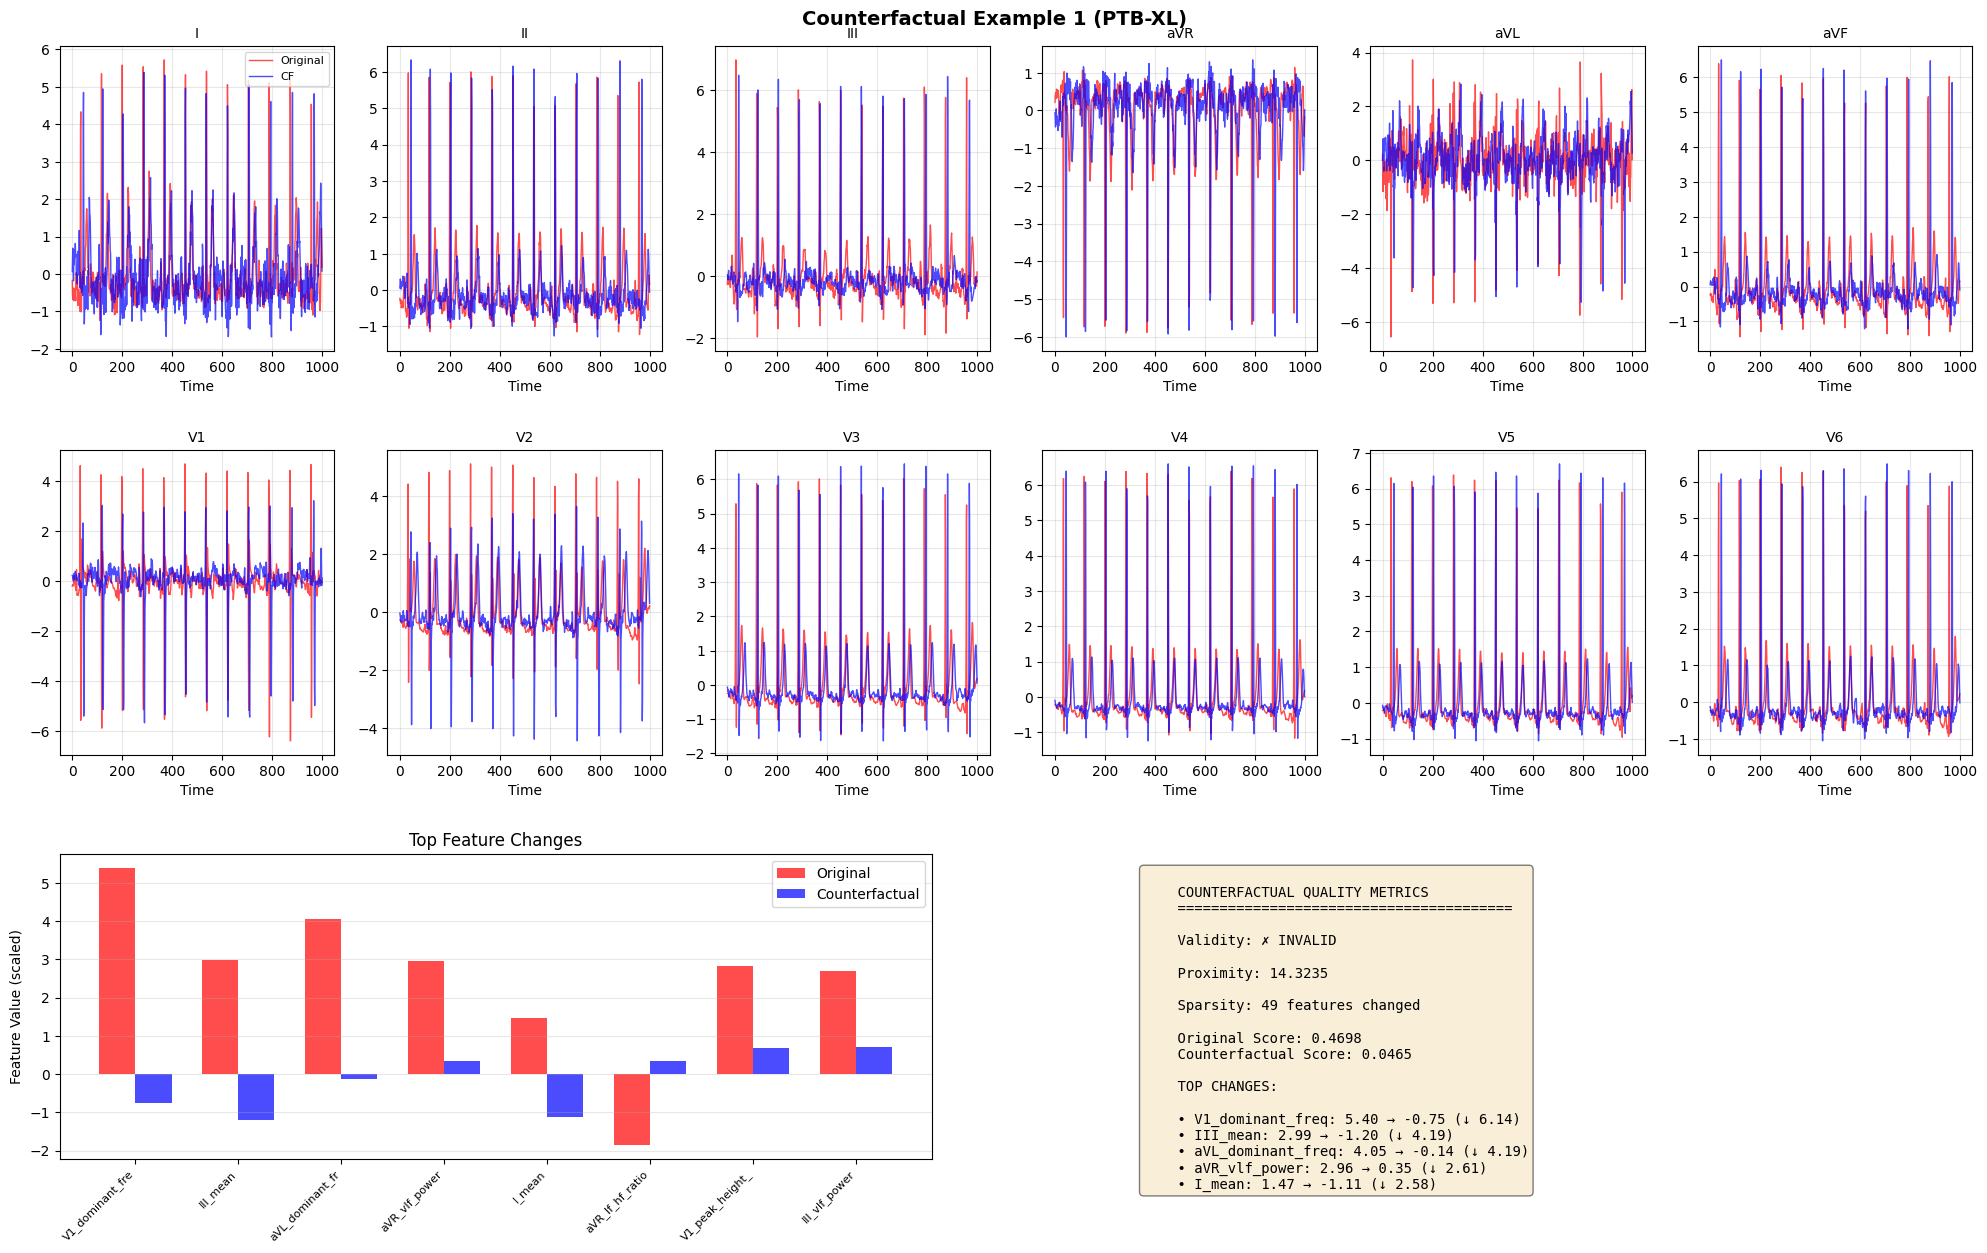

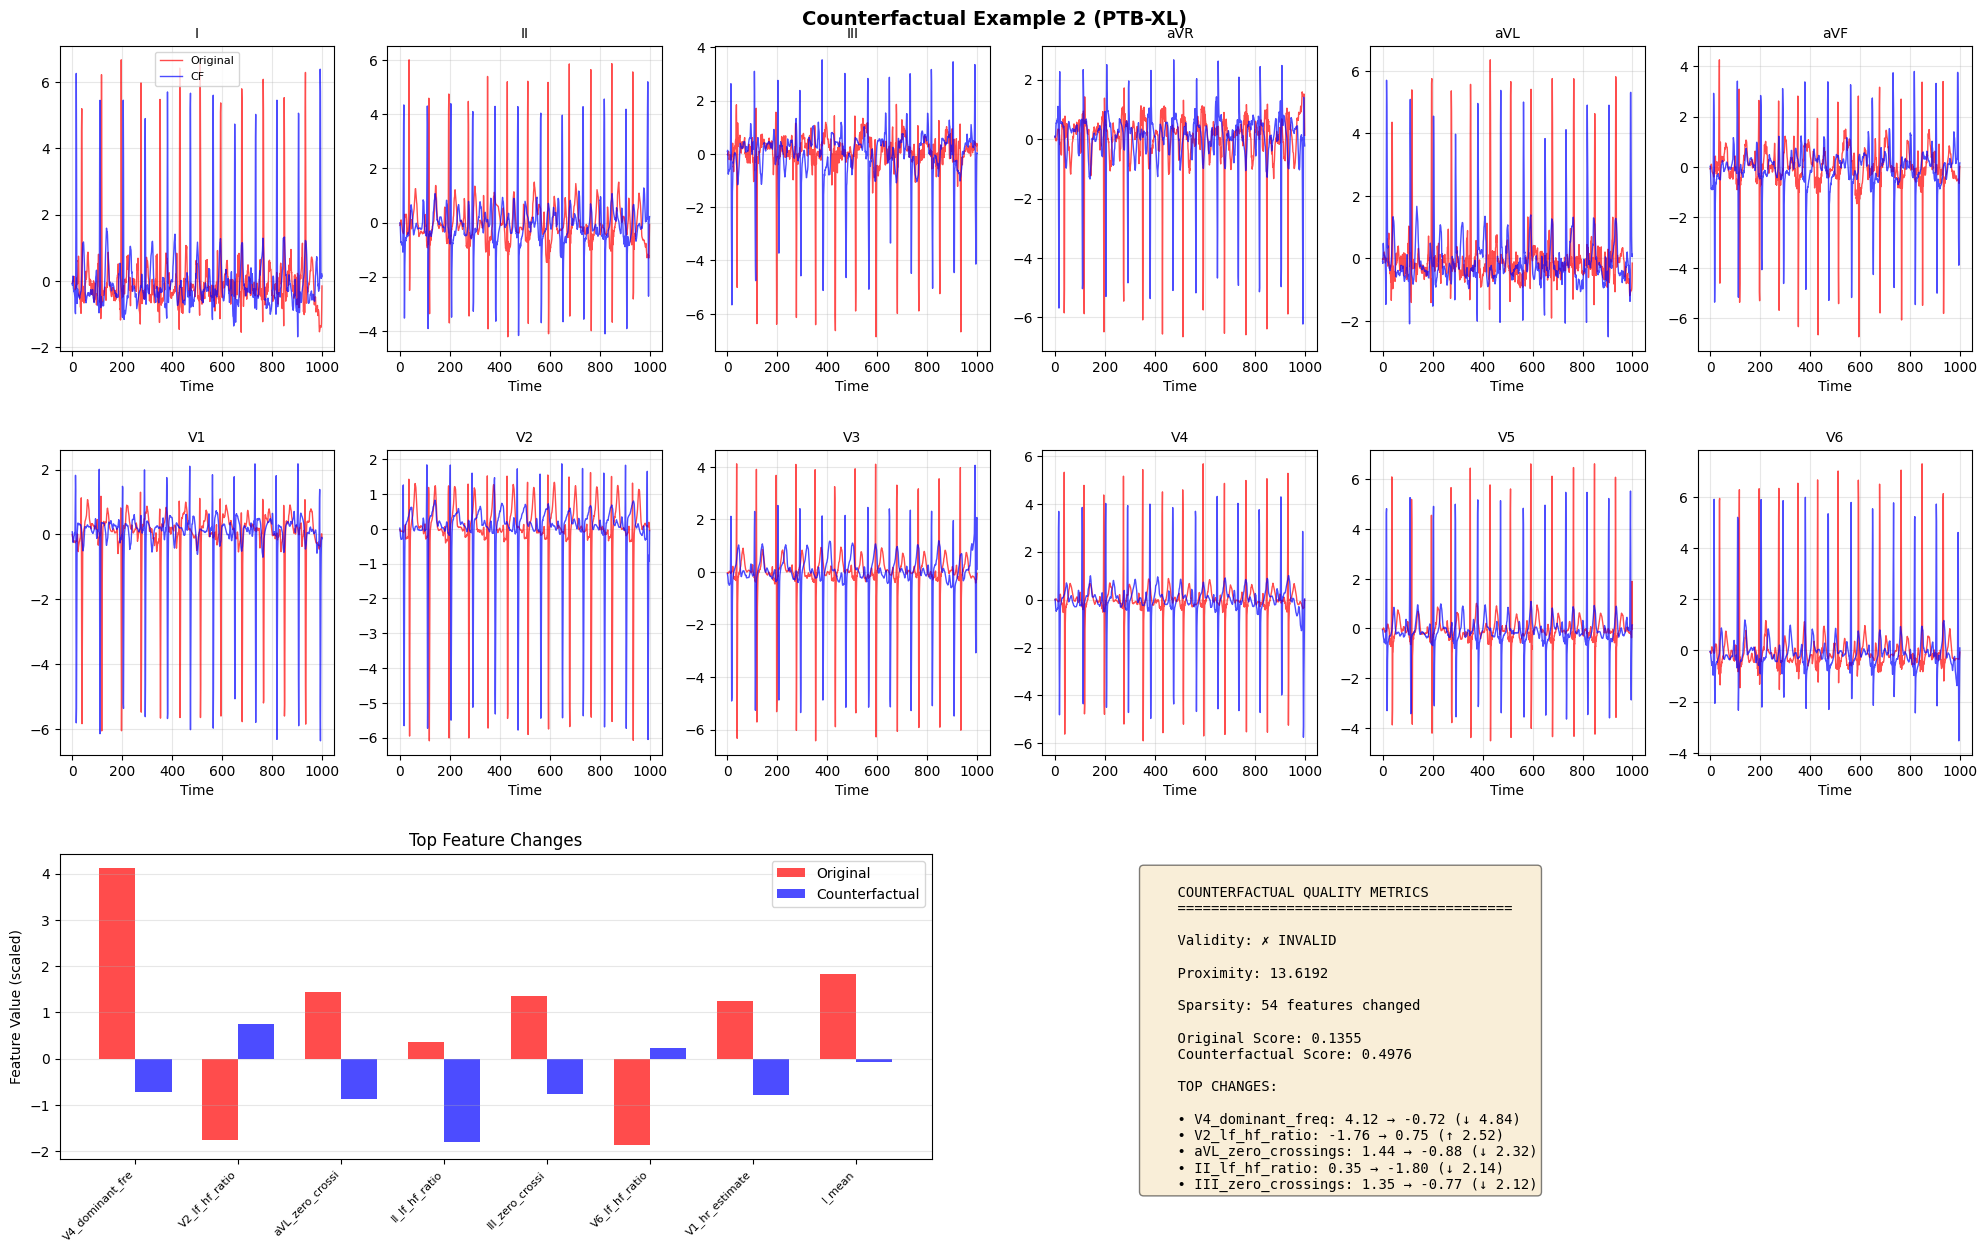

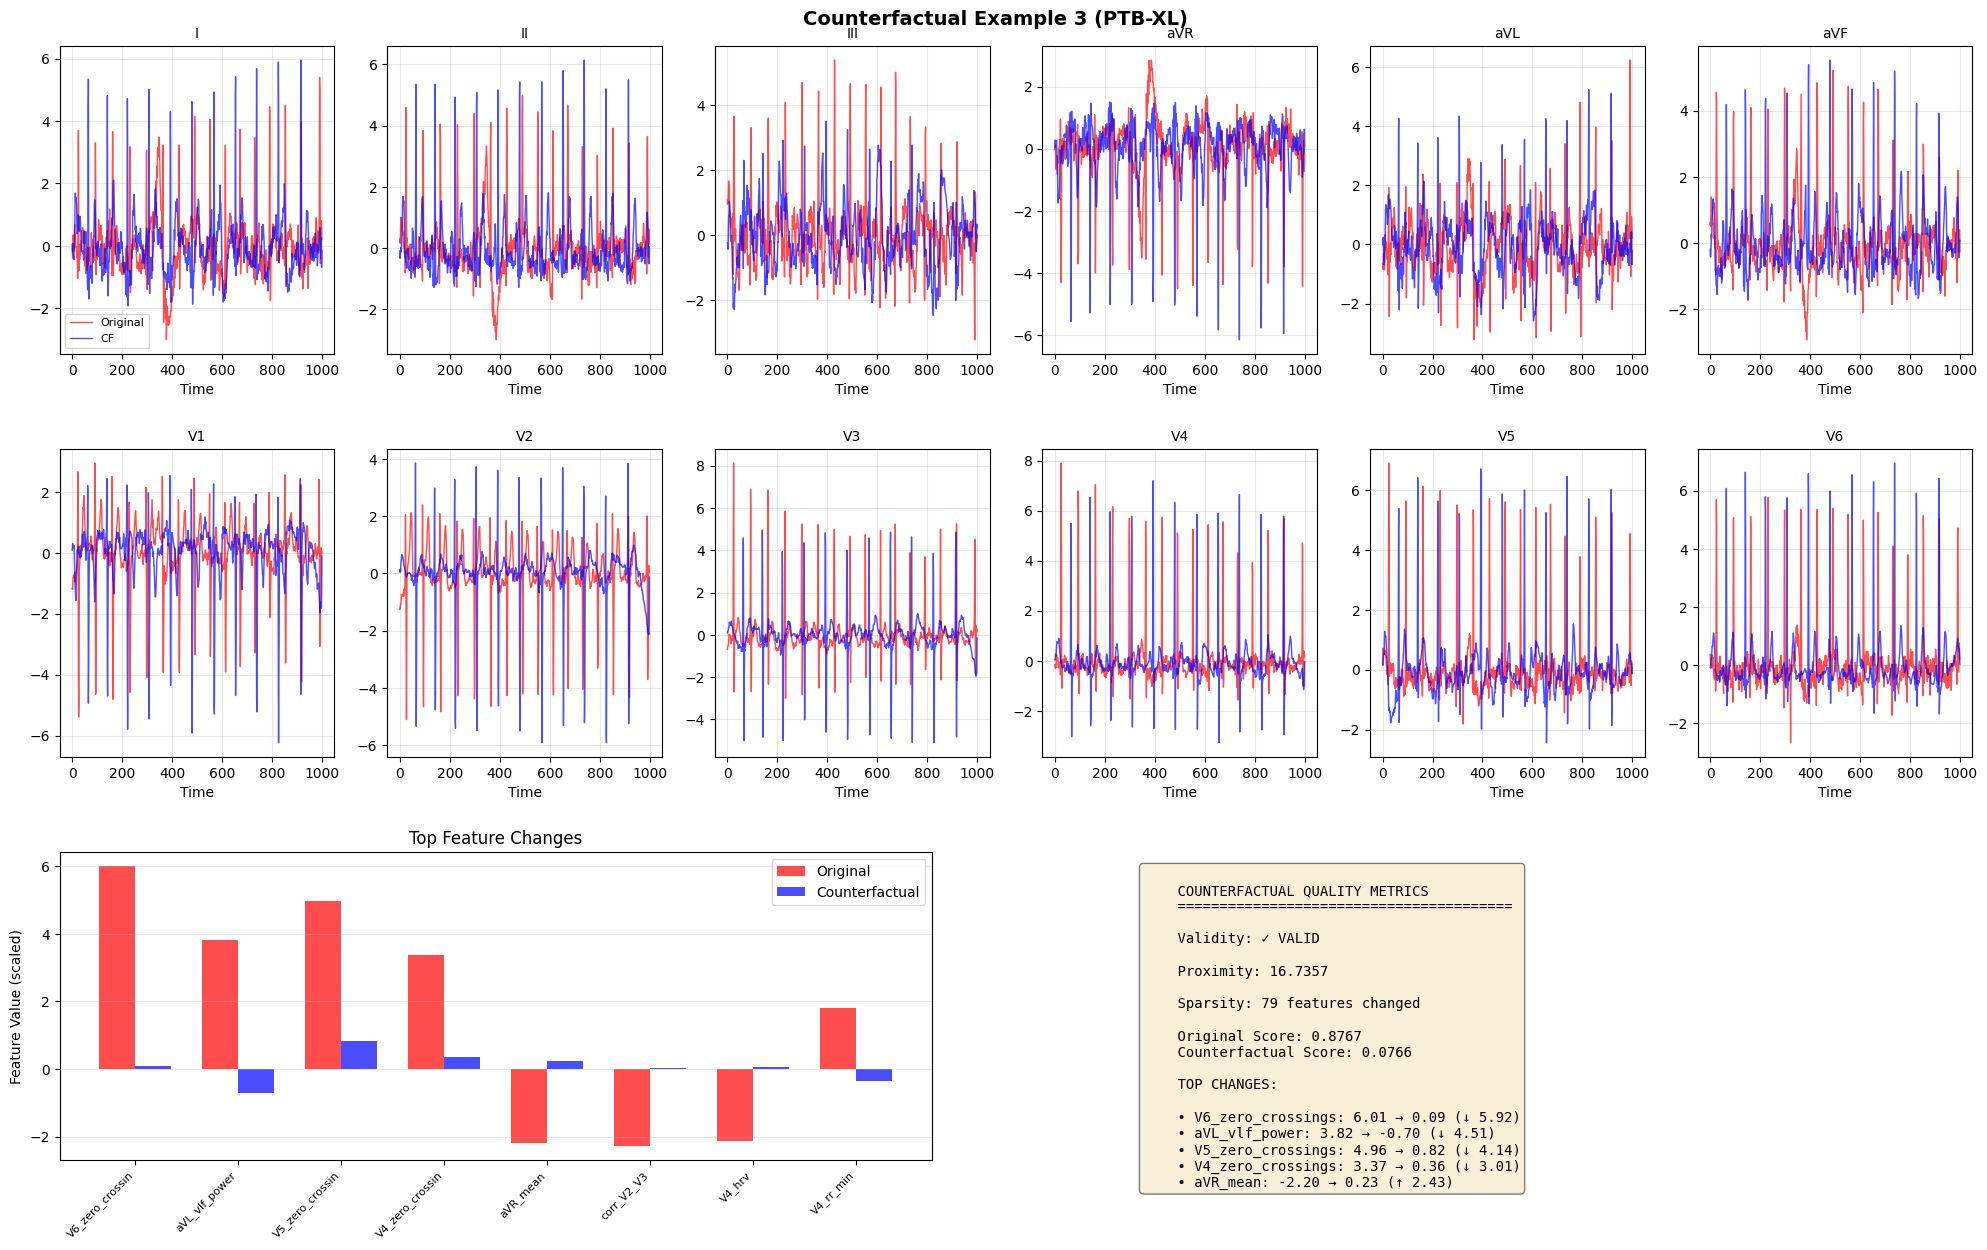

In [27]:
# visualise a few example counterfactuals
for i, cf in enumerate(counterfactuals[:3]):
    fig = visualize_counterfactual_12lead(cf, f"Counterfactual Example {i+1} (PTB-XL)")
    plt.savefig(f'counterfactual_example_ptbxl{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()

## LLM Clinical Explanations

In [28]:
@dataclass
class ClinicalExplanation:
    flag_reason: str              # why did the AI flag this ECG
    key_differences: List[str]    # what is the main differences from normal (3 items)
    interpretation_note: str      # what is the clinical context for these differences
    confidence_statement: str     # how reliable is this assessment
    
    raw_response: str = ""
    model_used: str = ""
    tokens_used: int = 0
    generation_time: float = 0.0

In [29]:
class LLMExplanationGenerator:
    # clinical context for ECG features
    FEATURE_CLINICAL_CONTEXT = {
        'hr_estimate': ('Heart rate', 'BPM', 'Normal resting: 60-100 BPM'),
        'rr_mean': ('R-R interval (time between beats)', 'samples', 'Regularity indicates rhythm stability'),
        'rr_std': ('R-R variability', 'samples', 'Higher values suggest irregular rhythm'),
        'rr_min': ('Minimum R-R interval', 'samples', 'Very short intervals may indicate ectopic beats'),
        'rr_max': ('Maximum R-R interval', 'samples', 'Long intervals may indicate pauses or blocks'),
        'hrv': ('Heart rate variability', 'ratio', 'Reflects autonomic nervous system function'),
        'n_peaks': ('Number of detected heartbeats', 'count', 'Should match expected for recording duration'),
        'peak_height_mean': ('Average R-wave amplitude', 'normalized units', 'Changes may reflect conduction abnormalities'),
        'peak_height_std': ('R-wave amplitude variability', 'normalized units', 'Consistency of ventricular depolarization'),
        'mean': ('Signal mean', 'units', 'Baseline level of the ECG'),
        'std': ('Signal standard deviation', 'units', 'Overall variability in the signal'),
        'var': ('Signal variance', 'units', 'Squared variability measure'),
        'min': ('Signal minimum', 'units', 'Lowest point in the ECG'),
        'max': ('Signal maximum', 'units', 'Highest point (typically R-peak)'),
        'range': ('Signal range', 'units', 'Difference between max and min'),
        'median': ('Signal median', 'units', 'Central value of the signal'),
        'skewness': ('Waveform asymmetry', 'units', 'May indicate ST segment changes'),
        'kurtosis': ('Waveform peakedness', 'units', 'Related to QRS morphology'),
        'rms': ('Root mean square', 'units', 'Signal energy measure'),
        'zero_crossings': ('Zero crossings', 'count', 'Frequency-related measure'),
        'total_power': ('Total spectral power', 'units', 'Overall signal energy'),
        'vlf_power': ('Very low frequency power', 'ratio', 'Long-term regulatory mechanisms'),
        'lf_power': ('Low frequency power', 'ratio', 'Sympathetic and parasympathetic activity'),
        'hf_power': ('High frequency power', 'ratio', 'Parasympathetic (vagal) activity'),
        'dominant_freq': ('Dominant frequency', 'Hz', 'Primary frequency component'),
        'spectral_entropy': ('Signal complexity', 'units', 'Lower values suggest more regular patterns'),
        'lf_hf_ratio': ('LF/HF ratio', 'ratio', 'Sympathovagal balance indicator'),
    }

    SYSTEM_PROMPT = """You are a clinical decision support assistant explaining 12 lead ECG anomaly detection results. Your role is NOT to diagnose or recommend actions, clinicians make those decisions. Your role is to explain WHY an time series counterfactual anomaly detection system flagged an ECG as potentially abnormal/an anomaly.

You translate technical counterfactual explanations into clear language. A counterfactual explanation works by answering: "What would need to be different about this ECG for it to appear normal?"

AUDIENCE: Your explanations must be understood by cardiologists, general practitioners and cardiac nurses so use precise but accessible language.

CRITICAL CONSTRAINTS:
- Never diagnose conditions or recommend clinical actions
- Never use phrases like "you should" or "this indicates [diagnosis]"
- Always frame explanations as "the AI flagged this because..." not "this patient has..."
- Keep the total explanation under 150 words
- Be honest about uncertainty asthese are computational patterns, not clinical diagnoses

OUTPUT FORMAT: Return ONLY valid JSON with no additional text, markdown or explanation."""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self._openai_client = None

    
    def _format_feature_changes(self, cf: CounterfactualExplanation, top_n: int = 7) -> str:
        lines = []
        
        for name, orig_val, cf_val, diff in cf.top_changes[:top_n]:
            parts = name.split('_')
            if parts[0] in LEAD_NAMES:
                lead = parts[0]
                feat = '_'.join(parts[1:])
                context = self.FEATURE_CLINICAL_CONTEXT.get(name, (name, 'units', ''))
                direction = "higher" if diff > 0 else "lower"
                line = f"- Lead {lead} {context[0]}: This ECG is {abs(diff):.2f} {context[1]} {direction} than the normal reference. {context[2]}"
            else: 
                context = self.FEATURE_CLINICAL_CONTEXT.get(name, (name, 'units', ''))
                direction = "higher" if diff > 0 else "lower"
                line = f"- {context[0]}: This ECG is {abs(diff):.2f} {context[1]} {direction} than the normal reference. {context[2]}"
            lines.append(line)
        
        return "\n".join(lines)

    def _build_user_prompt(self, cf: CounterfactualExplanation) -> str:
        feature_changes_text = self._format_feature_changes(cf)
        
        # simple confidence indicator based on the proximity
        if cf.proximity < 3.0:
            confidence_hint = "relatively close to normal patterns"
        elif cf.proximity < 6.0:
            confidence_hint = "moderately different from normal patterns"
        else:
            confidence_hint = "substantially different from normal patterns"
        
        return f"""A 12 lead ECG was flagged as potentially abnormal by an anomaly detection system. Below are the key differences between this ECG and the nearest "normal" reference ECG found by the system.

DETECTION INFO:
- Anomaly Score: {cf.original_score:.3f} (higher = more anomalous)
- Distance from nearest normal: {cf.proximity:.3f} ({confidence_hint})
- This is a 12-lead ECG with features extracted from all leads

FEATURE DIFFERENCES (what would need to change for this ECG to appear normal):
{feature_changes_text}

Translate this into a clinical explanation. Return ONLY valid JSON with exactly these fields:

{{
  "flag_reason": "One to two sentences explaining in plain English why the system flagged this ECG as abnormal. Start with 'This ECG was flagged because...'",
  
  "key_differences": [
    "First key difference between this ECG and normal reference (one sentence)",
    "Second key difference (one sentence)", 
    "Third key difference if relevant, otherwise omit this item (one sentence)"
  ],
  
  "interpretation_note": "One sentence providing clinical context for these differences, accessible to non specialists. Frame as 'These patterns may be associated with...' not as a diagnosis.",
  
  "confidence_statement": "One sentence about the reliability of this flag based on how different this ECG is from normal references."
}}"""

    def _parse_llm_response(self, response_text: str) -> dict:
        text = response_text.strip()
        
        # remove markdown blocks
        if text.startswith("```"):
            lines = text.split("\n")
            if lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].strip() == "```":
                lines = lines[:-1]
            text = "\n".join(lines)
        
        try:
            return json.loads(text)
        except json.JSONDecodeError:
            pass
        
        start = text.find('{')
        end = text.rfind('}')
        if start != -1 and end != -1 and end > start:
            try:
                return json.loads(text[start:end + 1])
            except json.JSONDecodeError:
                pass
        
        raise ValueError(f"Could not parse JSON from LLM response: {text[:200]}...")

    def _validate_response(self, data: dict) -> dict:
        required_fields = ['flag_reason', 'key_differences', 'interpretation_note', 'confidence_statement']
        
        for field in required_fields:
            if field not in data:
                raise ValueError(f"Missing required field: {field}")
        
        if not isinstance(data['key_differences'], list):
            data['key_differences'] = [str(data['key_differences'])]
        
        data['key_differences'] = data['key_differences'][:3]
        
        for field in ['flag_reason', 'interpretation_note', 'confidence_statement']:
            data[field] = str(data[field])
        
        return data

    def _generate_with_openai(self, cf: CounterfactualExplanation) -> Tuple[str, int]:
        if self._openai_client is None:
            try:
                from openai import OpenAI
            except ImportError:
                raise ImportError("openai package not installed")
            
            api_key = os.getenv(self.config.llm_api_key_env)
            if not api_key:
                raise ValueError(f"OpenAI API key not found in environment variable: {self.config.llm_api_key_env}")
            
            self._openai_client = OpenAI(api_key=api_key)
        
        user_prompt = self._build_user_prompt(cf)
        
        response = self._openai_client.chat.completions.create(
            model=self.config.llm_model,
            messages=[
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt}
            ],
            temperature=self.config.llm_temperature,
            max_tokens=self.config.llm_max_tokens,
            response_format={"type": "json_object"}  
        )
        
        response_text = response.choices[0].message.content
        tokens_used = response.usage.total_tokens if response.usage else 0
        
        return response_text, tokens_used

    # generate explanation for cf with structured fields
    def generate(self, cf: CounterfactualExplanation) -> ClinicalExplanation:
        start_time = time.perf_counter()
        
        backend = self.config.llm_backend.lower()
        
        try:
            if backend == 'openai':
                response_text, tokens_used = self._generate_with_openai(cf)
            elif backend == 'local':
                response_text, tokens_used = self._generate_with_local(cf)
            elif backend == 'gemini':
                response_text, tokens_used = self._generate_with_gemini(cf)
            else:
                raise ValueError(f"Unknown LLM backend: {backend}")
            
            data = self._parse_llm_response(response_text)
            data = self._validate_response(data)
            
            generation_time = time.perf_counter() - start_time
            
            return ClinicalExplanation(
                flag_reason=data['flag_reason'],
                key_differences=data['key_differences'],
                interpretation_note=data['interpretation_note'],
                confidence_statement=data['confidence_statement'],
                raw_response=response_text,
                model_used=self.config.llm_model if backend == 'openai' else self.config.llm_local_model,
                tokens_used=tokens_used,
                generation_time=generation_time
            )
            
        except Exception as e:
            generation_time = time.perf_counter() - start_time
            
            top_features = [name for name, _, _, _ in cf.top_changes[:3]]
            
            return ClinicalExplanation(
                flag_reason=f"Error generating explanation: {str(e)}",
                key_differences=f"",
                interpretation_note=f"Unable to generate clinicial context",
                confidence_statement=f"Error in explanation generation",
                raw_response=str(e),
                model_used="error",
                tokens_used=0,
                generation_time=generation_time
            )

In [30]:
def display_clinical_explanation(cf: CounterfactualExplanation, explanation: ClinicalExplanation):
    print("\n" + "="*70)
    print("CLINICAL EXPLANATION REPORT")
    print("="*70)
    
    print(f"\n WHY WAS THIS FLAGGED?")
    print("-"*50)
    print(explanation.flag_reason)
    
    print(f"\n KEY DIFFERENCES FROM NORMAL")
    print("-"*50)
    for i, diff in enumerate(explanation.key_differences, 1):
        print(f"  {i}. {diff}")
    
    print(f"\n CLINICAL CONTEXT")
    print("-"*50)
    print(explanation.interpretation_note)
    
    print(f"\nCONFIDENCE")
    print("-"*50)
    print(explanation.confidence_statement)
    
    print(f"\n METADATA")
    print("-"*50)
    print(f"  Model: {explanation.model_used}")
    print(f"  Tokens: {explanation.tokens_used}")
    print(f"  Time: {explanation.generation_time:.2f}s")
    
    print("\n" + "="*70)

In [31]:
llm_generator = LLMExplanationGenerator(config)
api_key = os.getenv(config.llm_api_key_env)
if not api_key:
    print(f"Warning: {config.llm_api_key_env} not set")
    config.llm_backend = 'local'
else:
    print(f"API key found. Using {config.llm_model}")

print("Generating clinical explanations...\n")

for i, cf in enumerate(counterfactuals[:3]):
    print(f"\n{'#'*70}")
    print(f"# EXAMPLE {i+1}")
    print(f"{'#'*70}")
    
    explanation = llm_generator.generate(cf)
    display_clinical_explanation(cf, explanation)

API key found. Using gpt-4o-mini
Generating clinical explanations...


######################################################################
# EXAMPLE 1
######################################################################

CLINICAL EXPLANATION REPORT

 WHY WAS THIS FLAGGED?
--------------------------------------------------
This ECG was flagged because it shows significant differences in several key features compared to normal reference patterns.

 KEY DIFFERENCES FROM NORMAL
--------------------------------------------------
  1. Lead V1 shows a dominant frequency that is 6.14 units lower than the normal reference.
  2. Lead III has a mean value that is 4.19 units lower than the normal reference.
  3. Lead aVR has a low-frequency to high-frequency power ratio that is 2.21 units higher than the normal reference.

 CLINICAL CONTEXT
--------------------------------------------------
These patterns may be associated with variations in cardiac electrical activity.

CONFIDENCE
----------

## Explainable ECG Pipeline

In [32]:
@dataclass
class PipelineResult:
    ecg_signal: np.ndarray
    ecg_id: str
    
    #1. detection
    is_anomaly: bool
    anomaly_score: float
    detection_confidence: float
    
    #2. counterfactual 
    counterfactual: Optional[CounterfactualExplanation]
    
    #3. clinical explanation
    clinical_explanation: Optional[ClinicalExplanation]
    
    processing_time: float = 0.0

In [33]:
class ExplainableECGPipeline:
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.preprocessor = ECGPreprocessor(config)
        self.feature_extractor = ECGFeatureExtractor(config)
        self.feature_scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.cnn_detector = CNNAnomalyDetector(config)
        self.cf_generator: Optional[NearestNeighbourCounterfactual] = None
        self.llm_generator = LLMExplanationGenerator(config)

    def fit(self, X_signals: np.ndarray, y: np.ndarray) -> "ExplainableECGPipeline":
        if not hasattr(self, "imputer") or self.imputer is None:
            self.imputer = SimpleImputer(strategy='median')

        X_processed = self.preprocessor.preprocess(X_signals)
        X_features = self.feature_extractor.transform(X_processed)

        X_features = self.imputer.fit_transform(X_features)
        X_features = np.nan_to_num(X_features, nan=0.0)

        self.feature_scaler.fit(X_features)
        X_scaled = self.feature_scaler.transform(X_features)

        self.cnn_detector.fit(X_processed, y)

        self.cf_generator = NearestNeighbourCounterfactual(
            config=self.config,
            detector=self.cnn_detector,
            feature_names=self.feature_extractor.feature_names
        )
        self.cf_generator.fit(X_processed, X_scaled, y)
        return self

    def _confidence_from_score(self, score: float) -> float:
        return float(np.clip(score, 0.0, 1.0))

    def predict(self, ecg_signal: np.ndarray, ecg_id: str, 
                generate_explanation: bool = True) -> PipelineResult:
        start_time = time.perf_counter()
        
        X_processed = self.preprocessor.preprocess(ecg_signal if ecg_signal.ndim == 3 else ecg_signal[np.newaxis, :, :])
        X_features = self.feature_extractor.transform(X_processed)
        if not hasattr(self, "imputer") or self.imputer is None:
            self.imputer = SimpleImputer(strategy='median')
        X_features = self.imputer.transform(X_features)
        X_features = np.nan_to_num(X_features, nan=0.0, posinf=0.0, neginf=0.0)
        X_scaled = self.feature_scaler.transform(X_features)

        is_anomaly = bool(self.cnn_detector.predict(X_processed)[0])
        anomaly_score = float(self.cnn_detector.decision_function(X_processed)[0])
        detection_confidence = self._confidence_from_score(anomaly_score)

        counterfactual = None
        clinical_explanation = None
        
        if is_anomaly and self.cf_generator is not None:
            sig = X_processed[0] if X_processed.ndim == 3 else X_processed
            counterfactual = self.cf_generator.generate(sig, X_scaled[0])
            
            if generate_explanation:
                clinical_explanation = self.llm_generator.generate(counterfactual)

        processing_time = time.perf_counter() - start_time

        return PipelineResult(
            ecg_signal=ecg_signal,
            ecg_id=ecg_id,
            is_anomaly=is_anomaly,
            anomaly_score=anomaly_score,
            detection_confidence=detection_confidence,
            counterfactual=counterfactual,
            clinical_explanation=clinical_explanation,
            processing_time=processing_time
        )

In [34]:
pipeline = ExplainableECGPipeline(config)
pipeline.fit(X_train, y_train)

Extracting features: 100%|██████████| 18323/18323 [03:09<00:00, 96.54it/s] 


Epoch 1/10 - train_loss=0.3219 val_loss=0.2797
Epoch 2/10 - train_loss=0.2758 val_loss=0.7043
Epoch 3/10 - train_loss=0.2665 val_loss=0.3249
Epoch 4/10 - train_loss=0.2565 val_loss=0.2766
Epoch 5/10 - train_loss=0.2517 val_loss=0.2622
Epoch 6/10 - train_loss=0.2498 val_loss=0.2646
Epoch 7/10 - train_loss=0.2434 val_loss=0.2593
Epoch 8/10 - train_loss=0.2430 val_loss=0.2787
Epoch 9/10 - train_loss=0.2419 val_loss=0.2816
Epoch 10/10 - train_loss=0.2428 val_loss=0.2534
Calibrated CNN threshold for recall>=0.85: 0.4960
Counterfactual generator fitted on 8129 normal samples


In [35]:
print("\n" + "="*60)
print("RUNNING PIPELINE ON TEST SAMPLES")
print("="*60)

test_indices = [0, 1, 2]

for idx in test_indices:
    result = pipeline.predict(X_test[idx], f"PTBXL_TEST_{idx:04d}")
    
    print(f"\n{'='*60}")
    print(f"ECG ID: {result.ecg_id}")
    print(f"Ground Truth: {'Anomaly' if y_test[idx] == 1 else 'Normal'}")
    print(f"Prediction: {'Anomaly' if result.is_anomaly else 'Normal'}")
    print(f"Anomaly Score: {result.anomaly_score:.4f}")
    print(f"Detection Confidence: {result.detection_confidence:.2%}")
    print(f"Processing Time: {result.processing_time:.3f}s")
    
    if result.clinical_explanation:
        print(f"\n--- Clinical Explanation ---")
        print(f"Flag Reason: {result.clinical_explanation.flag_reason}")


RUNNING PIPELINE ON TEST SAMPLES


Extracting features: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]



ECG ID: PTBXL_TEST_0000
Ground Truth: Normal
Prediction: Normal
Anomaly Score: 0.0640
Detection Confidence: 6.40%
Processing Time: 0.113s


Extracting features: 100%|██████████| 1/1 [00:00<00:00, 62.70it/s]



ECG ID: PTBXL_TEST_0001
Ground Truth: Normal
Prediction: Anomaly
Anomaly Score: 0.5420
Detection Confidence: 54.20%
Processing Time: 3.518s

--- Clinical Explanation ---
Flag Reason: This ECG was flagged because it shows significant deviations in several key features compared to normal reference patterns.


Extracting features: 100%|██████████| 1/1 [00:00<00:00, 82.15it/s]


ECG ID: PTBXL_TEST_0002
Ground Truth: Normal
Prediction: Normal
Anomaly Score: 0.1024
Detection Confidence: 10.24%
Processing Time: 0.020s


## Pipeline Evaluation

In [36]:
def comprehensive_evaluation(pipeline: ExplainableECGPipeline, 
                             X_test: np.ndarray, y_test: np.ndarray) -> Dict:
    results = {}
    
    X_processed = pipeline.preprocessor.preprocess(X_test)
    X_features = pipeline.feature_extractor.transform(X_processed)
    X_features = pipeline.imputer.transform(X_features)
    X_features = np.nan_to_num(X_features, nan=0.0, posinf=0.0, neginf=0.0)
    X_scaled = pipeline.feature_scaler.transform(X_features)
    
    print("\n" + "="*60)
    print("DETECTION LAYER EVALUATION")
    print("="*60)
    
    y_pred = pipeline.cnn_detector.predict(X_processed)
    scores = pipeline.cnn_detector.decision_function(X_processed)
    
    results['detection'] = {
        'auroc': roc_auc_score(y_test, scores),
        'auprc': average_precision_score(y_test, scores),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }
    
    print(f"\nMetrics:")
    for name, value in results['detection'].items():
        print(f"  {name.upper()}: {value:.4f}")
    
    print("\n" + "="*60)
    print("COUNTERFACTUAL LAYER EVALUATION")
    print("="*60)
    
    anomaly_indices = np.where(y_test == 1)[0]
    n_samples = min(50, len(anomaly_indices))
    counterfactuals = []
    
    for idx in tqdm(anomaly_indices[:50], desc="Generating counterfactuals"):
        cf = pipeline.cf_generator.generate(X_processed[idx], X_scaled[idx])
        counterfactuals.append(cf)
    
    results['counterfactual'] = {
        'validity_rate': np.mean([cf.validity for cf in counterfactuals]),
        'mean_proximity': np.mean([cf.proximity for cf in counterfactuals]),
        'std_proximity': np.std([cf.proximity for cf in counterfactuals]),
        'mean_sparsity': np.mean([cf.sparsity for cf in counterfactuals])
    }
    
    print(f"\nMetrics (on {len(counterfactuals)} samples):")
    print(f"  Validity Rate: {results['counterfactual']['validity_rate']:.2%}")
    print(f"  Mean Proximity: {results['counterfactual']['mean_proximity']:.4f} ± {results['counterfactual']['std_proximity']:.4f}")
    print(f"  Mean Sparsity: {results['counterfactual']['mean_sparsity']:.1f} features")
    
    return results

In [37]:
evaluation_results = comprehensive_evaluation(pipeline, X_test_raw, y_test)

Extracting features: 100%|██████████| 2050/2050 [00:20<00:00, 98.87it/s] 



DETECTION LAYER EVALUATION

Metrics:
  AUROC: 0.9402
  AUPRC: 0.9587
  F1: 0.8661
  PRECISION: 0.9332
  RECALL: 0.8081

COUNTERFACTUAL LAYER EVALUATION


Generating counterfactuals: 100%|██████████| 50/50 [00:00<00:00, 133.96it/s]


Metrics (on 50 samples):
  Validity Rate: 82.00%
  Mean Proximity: 4239.1043 ± 1642.8658
  Mean Sparsity: 144.1 features


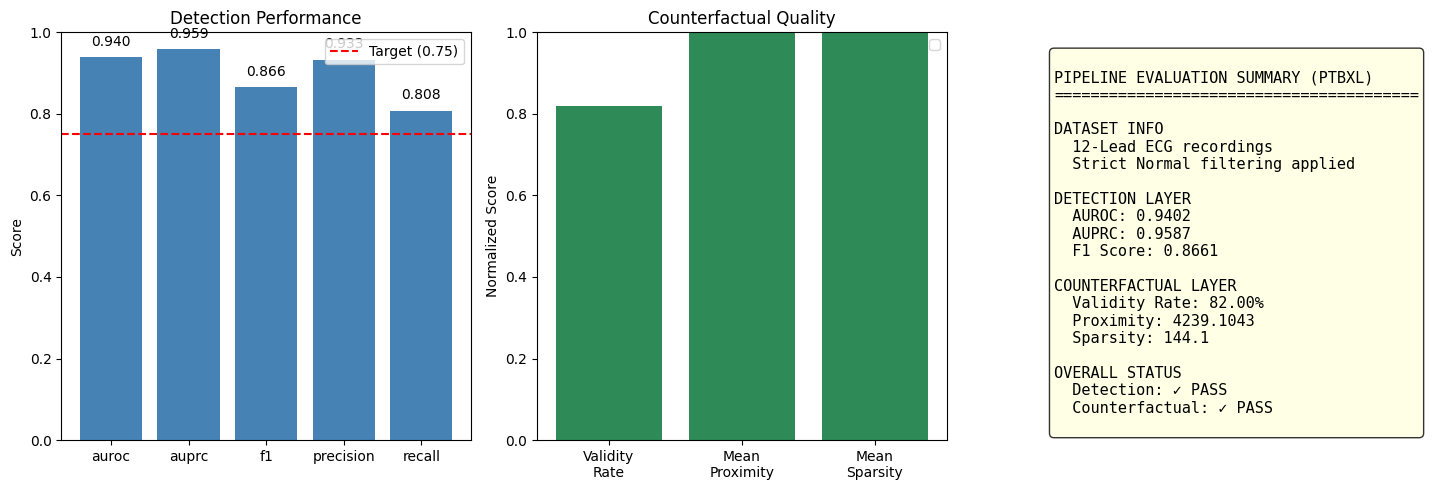

In [38]:
# visualise evaluation results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

detection_metrics = evaluation_results['detection']
ax1 = axes[0]
bars = ax1.bar(detection_metrics.keys(), detection_metrics.values(), color='steelblue')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score')
ax1.set_title('Detection Performance')
ax1.axhline(y=0.75, color='r', linestyle='--', label='Target (0.75)')
ax1.legend()
for bar, val in zip(bars, detection_metrics.values()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

cf_metrics = evaluation_results['counterfactual']
ax2 = axes[1]
cf_labels = ['Validity\nRate', 'Mean\nProximity', 'Mean\nSparsity']
cf_values = [cf_metrics['validity_rate'], 
             cf_metrics['mean_proximity'] / 5,
             cf_metrics['mean_sparsity'] / 10]
bars = ax2.bar(cf_labels, cf_values, color='seagreen')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Normalized Score')
ax2.set_title('Counterfactual Quality')
ax2.legend()

ax3 = axes[2]
ax3.axis('off')
summary_text = f"""
PIPELINE EVALUATION SUMMARY (PTBXL)
{'='*40}

DATASET INFO
  12-Lead ECG recordings
  Strict Normal filtering applied

DETECTION LAYER
  AUROC: {detection_metrics['auroc']:.4f}
  AUPRC: {detection_metrics['auprc']:.4f}
  F1 Score: {detection_metrics['f1']:.4f}

COUNTERFACTUAL LAYER
  Validity Rate: {cf_metrics['validity_rate']:.2%}
  Proximity: {cf_metrics['mean_proximity']:.4f}
  Sparsity: {cf_metrics['mean_sparsity']:.1f}

OVERALL STATUS
  Detection: {'✓ PASS' if detection_metrics['auroc'] >= 0.75 else '✗ NEEDS WORK'}
  Counterfactual: {'✓ PASS' if cf_metrics['validity_rate'] >= 0.80 else '✗ NEEDS WORK'}
"""
ax3.text(0.1, 0.95, summary_text, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('pipeline_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

## Generate Clinical Report

In [39]:
def generate_clinical_report(result: PipelineResult) -> str:
    report = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                       ECG ANALYSIS REPORT                            ║
╠══════════════════════════════════════════════════════════════════════╣
║ ECG ID: {result.ecg_id:<60} ║
║ Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'):<52} ║
╠══════════════════════════════════════════════════════════════════════╣
║ DETECTION RESULT                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║ Classification: {'ABNORMAL' if result.is_anomaly else 'NORMAL':<57} ║
║ Anomaly Score: {result.anomaly_score:>8.4f}                                          ║
║ Confidence: {result.detection_confidence:>6.1%}                                             ║
╠══════════════════════════════════════════════════════════════════════╣
"""
    
    if result.is_anomaly and result.clinical_explanation:
        exp = result.clinical_explanation
        key_diff_text = "\n".join([f"  • {diff}" for diff in exp.key_differences])
        
        report += f"""
║ CLINICAL INTERPRETATION                                              ║
╠══════════════════════════════════════════════════════════════════════╣

WHY THIS ECG WAS FLAGGED:
{exp.flag_reason}

KEY DIFFERENCES FROM NORMAL:
{key_diff_text}

CLINICAL CONTEXT:
{exp.interpretation_note}

CONFIDENCE ASSESSMENT:
{exp.confidence_statement}

╠══════════════════════════════════════════════════════════════════════╣
║ This is AI-assisted analysis. Clinical judgment is required.      ║
║ This explanation is for decision support, not diagnosis.             ║
╚══════════════════════════════════════════════════════════════════════╝
"""
    else:
        report += """
║ No significant abnormalities detected by the AI system.              ║
║ Standard clinical follow-up as indicated.                            ║
╚══════════════════════════════════════════════════════════════════════╝
"""
    
    return report

In [40]:
print("\n" + "#"*70)
print("#" + " "*22 + "CLINICAL CASE STUDIES" + " "*17 + "#")
print("#"*70)

# find the correctly detected anomalies
X_test_processed = pipeline.preprocessor.preprocess(X_test)
predictions = pipeline.cnn_detector.predict(X_test_processed)

detected_anomalies = [
    i for i in range(len(X_test)) 
    if y_test[i] == 1 and predictions[i] == 1
]

print(f"\nFound {len(detected_anomalies)} correctly detected anomalies.")


######################################################################
#                      CLINICAL CASE STUDIES                 #
######################################################################

Found 922 correctly detected anomalies.


Extracting features: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]



╔══════════════════════════════════════════════════════════════════════╗
║                       ECG ANALYSIS REPORT                            ║
╠══════════════════════════════════════════════════════════════════════╣
║ ECG ID: CASE_001                                                     ║
║ Analysis Date: 2026-02-01 13:37:20                                  ║
╠══════════════════════════════════════════════════════════════════════╣
║ DETECTION RESULT                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║ Classification: ABNORMAL                                                  ║
║ Anomaly Score:   0.8195                                          ║
║ Confidence:  81.9%                                             ║
╠══════════════════════════════════════════════════════════════════════╣

║ CLINICAL INTERPRETATION                                              ║
╠═════════════════════════════════════════════════════

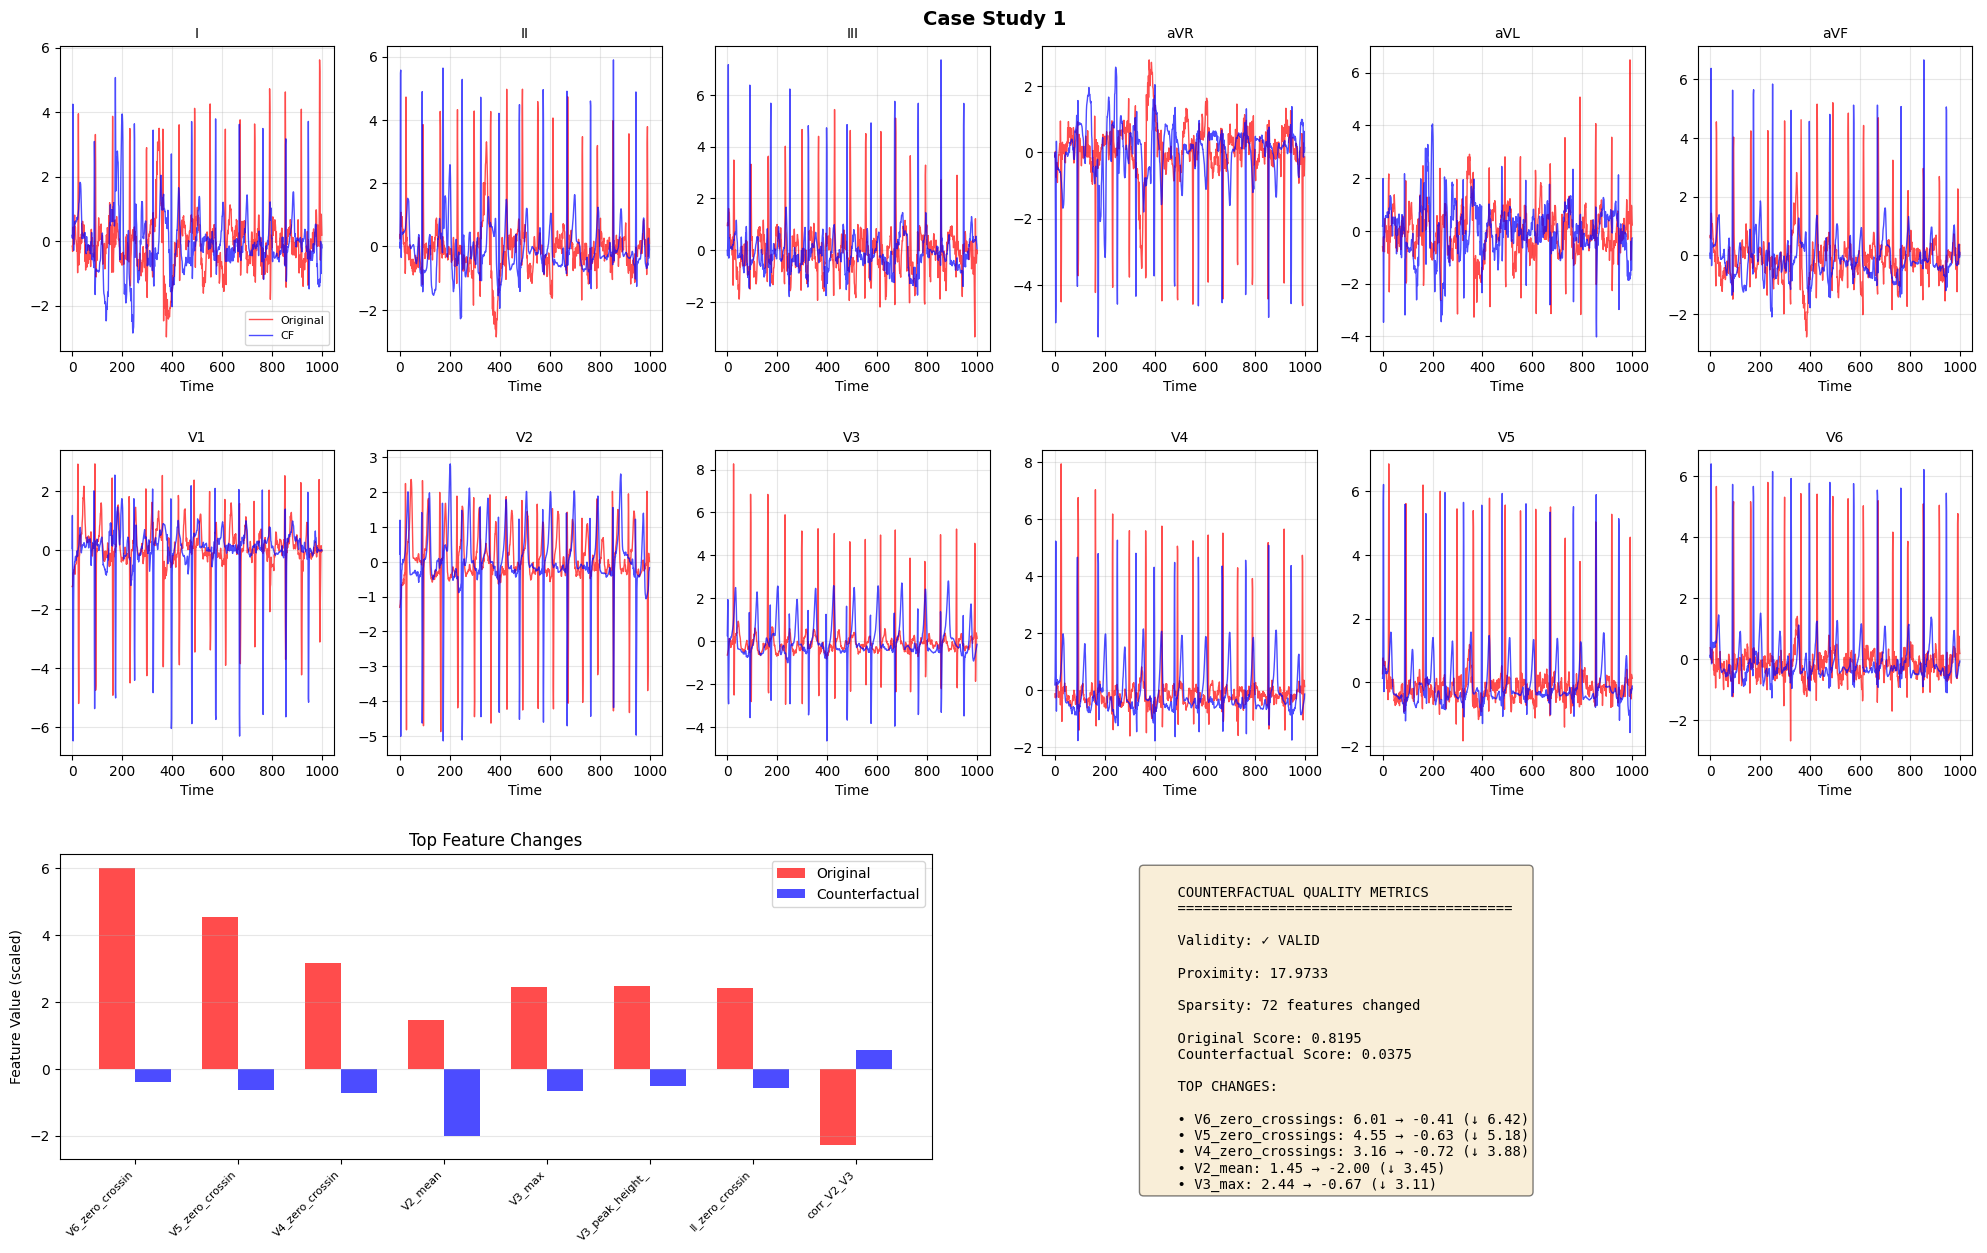

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 75.50it/s]



╔══════════════════════════════════════════════════════════════════════╗
║                       ECG ANALYSIS REPORT                            ║
╠══════════════════════════════════════════════════════════════════════╣
║ ECG ID: CASE_002                                                     ║
║ Analysis Date: 2026-02-01 13:37:28                                  ║
╠══════════════════════════════════════════════════════════════════════╣
║ DETECTION RESULT                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║ Classification: ABNORMAL                                                  ║
║ Anomaly Score:   0.8116                                          ║
║ Confidence:  81.2%                                             ║
╠══════════════════════════════════════════════════════════════════════╣

║ CLINICAL INTERPRETATION                                              ║
╠═════════════════════════════════════════════════════

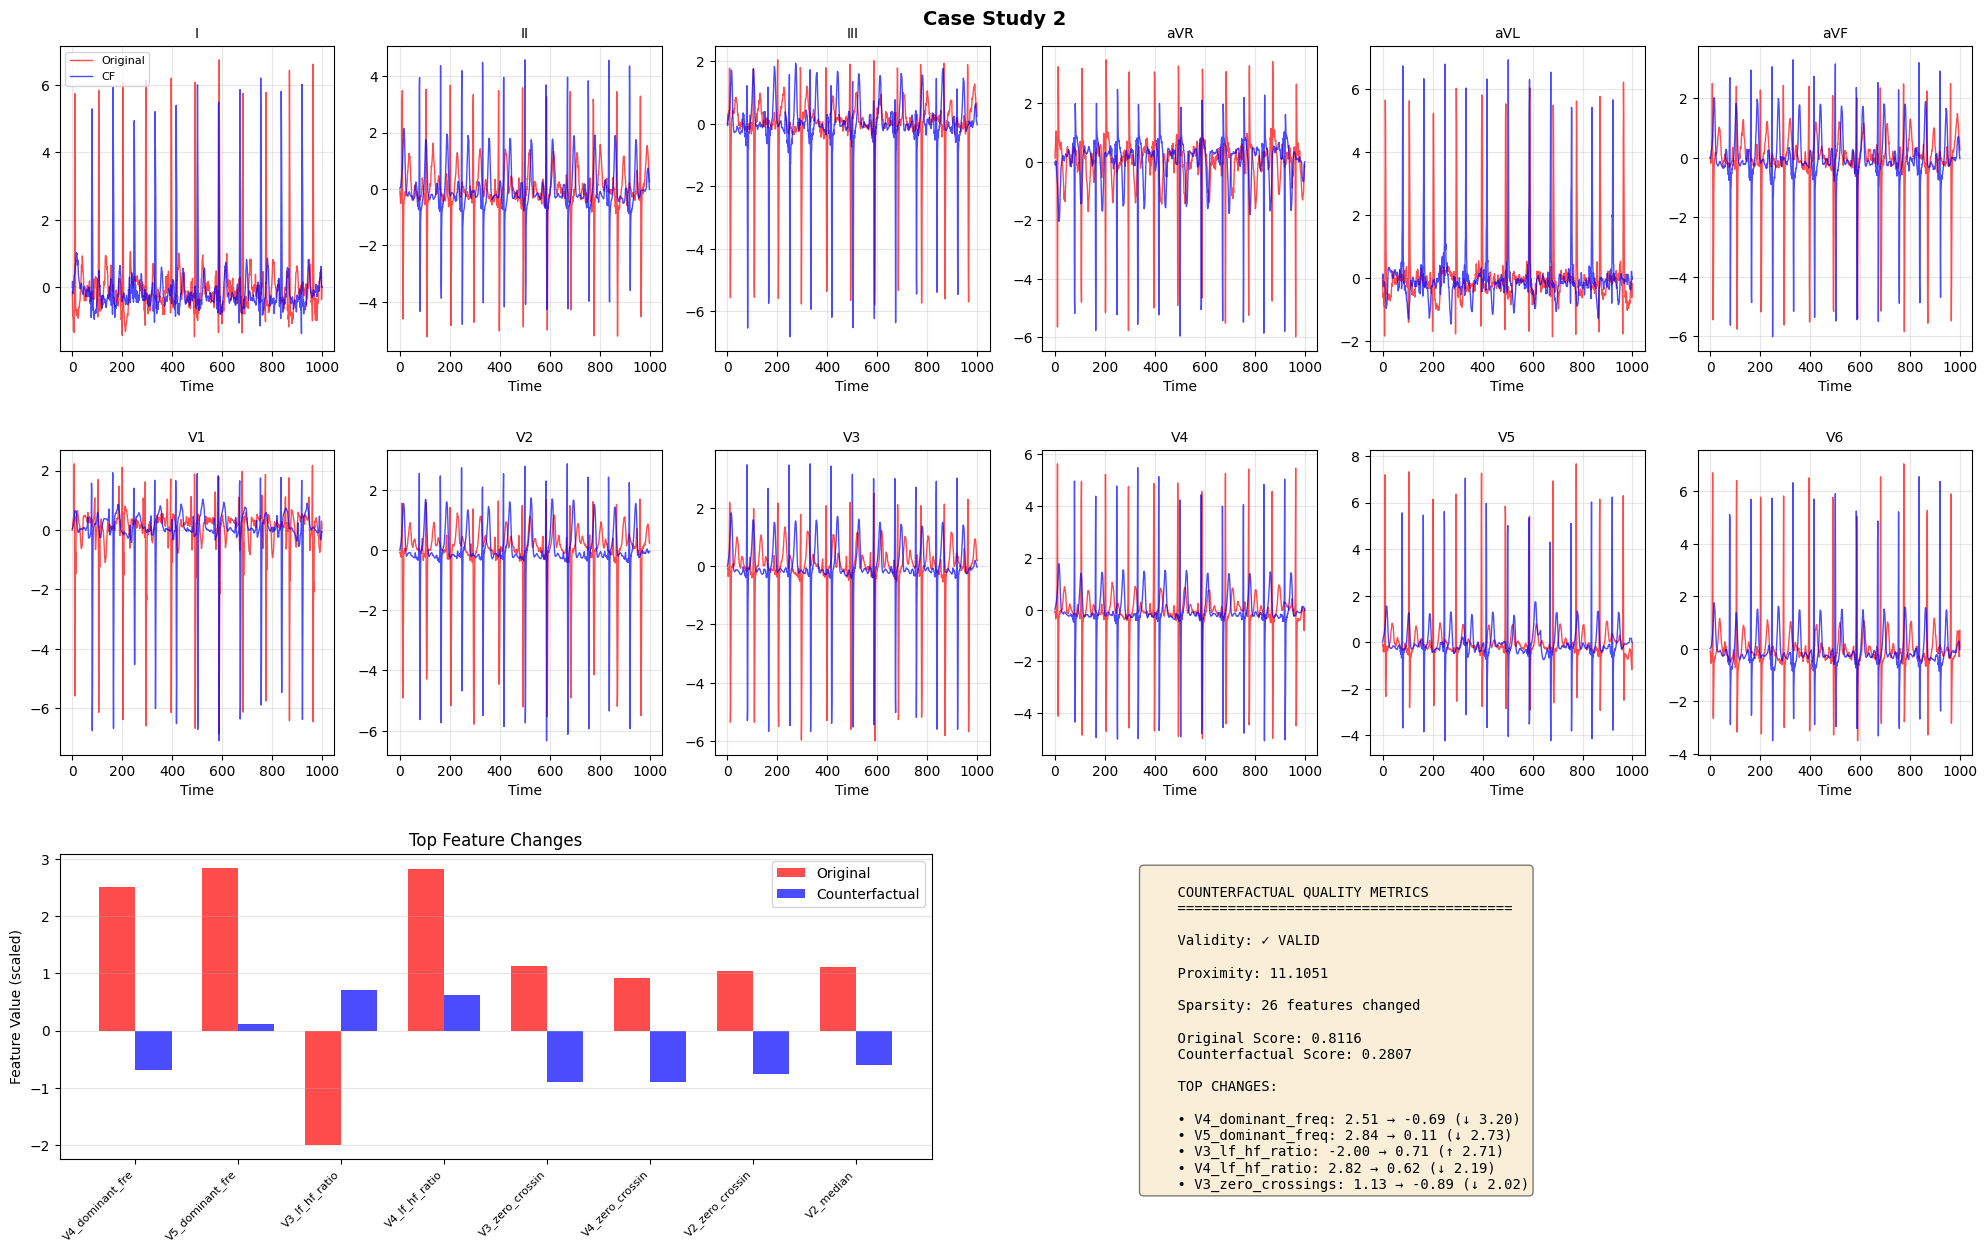

In [41]:
for i, idx in enumerate(detected_anomalies[:2]):
    result = pipeline.predict(X_test[idx], f"CASE_{i+1:03d}")
    report = generate_clinical_report(result)
    print(report)
    
    if result.counterfactual:
        fig = visualize_counterfactual_12lead(result.counterfactual, f"Case Study {i+1}")
        plt.savefig(f'case_study_ptbxl{i+1}.png', dpi=150, bbox_inches='tight')
        plt.show()

## Export Results

In [42]:
def _to_jsonable(obj):
    if isinstance(obj, dict):
        return {str(k): _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [_to_jsonable(v) for v in obj]
    if isinstance(obj, np.ndarray):
        return [_to_jsonable(v) for v in obj.tolist()]
    if isinstance(obj, np.generic):
        return obj.item()
    return obj

In [43]:
def export_explanations_for_evaluation(pipeline: ExplainableECGPipeline,
                                       X_test: np.ndarray, 
                                       y_test: np.ndarray,
                                       n_samples: int = 20,
                                       output_path: str = "explanations_for_evaluation.json") -> List[Dict]:
    anomaly_indices = np.where(y_test == 1)[0]
    
    if len(anomaly_indices) < n_samples:
        n_samples = len(anomaly_indices)
    
    np.random.seed(RANDOM_STATE)
    selected_indices = np.random.choice(anomaly_indices, size=n_samples, replace=False)
    
    evaluation_data = []
    
    print(f"Generating {n_samples} explanations for evaluation...")
    
    for i, idx in enumerate(tqdm(selected_indices)):
        result = pipeline.predict(X_test[idx], f"EVAL_{i:03d}")
        
        if result.clinical_explanation and result.counterfactual:
            exp = result.clinical_explanation
            cf = result.counterfactual
            
            record = {
                "id": result.ecg_id,
                "sample_index": int(idx),
                "ground_truth": "anomaly",
                "predicted": "anomaly" if result.is_anomaly else "normal",
                "anomaly_score": round(result.anomaly_score, 4),
                "detection_confidence": round(result.detection_confidence, 4),
                
                "explanation": {
                    "flag_reason": exp.flag_reason,
                    "key_differences": exp.key_differences,
                    "interpretation_note": exp.interpretation_note,
                    "confidence_statement": exp.confidence_statement
                },
                
                # cf quality metrics
                "counterfactual_metrics": {
                    "validity": cf.validity,
                    "proximity": round(cf.proximity, 4),
                    "sparsity": cf.sparsity
                },
                
                # top feature changes 
                "top_feature_changes": [
                    {
                        "feature": name,
                        "original_value": round(orig, 4),
                        "counterfactual_value": round(cf_val, 4),
                        "difference": round(diff, 4)
                    }
                    for name, orig, cf_val, diff in cf.top_changes[:5]
                ],
                
                "model_used": exp.model_used,
                "generation_time": round(exp.generation_time, 3)
            }
            
            evaluation_data.append(_to_jsonable(record))

    with open(output_path, 'w') as f:
        json.dump(evaluation_data, f, indent=2)
    
    print(f"\nExported {len(evaluation_data)} explanations to: {output_path}")
    
    return evaluation_data

In [44]:
evaluation_export = export_explanations_for_evaluation(
    pipeline, X_test, y_test, 
    n_samples=min(20, len(np.where(y_test == 1)[0])),
    output_path="explanations_for_evaluation.json"
)

print("\nSample evaluation record:")
print(json.dumps(evaluation_export[0], indent=2))

Generating 20 explanations for evaluation...


100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Exported 17 explanations to: explanations_for_evaluation.json

Sample evaluation record:
{
  "id": "EVAL_000",
  "sample_index": 1939,
  "ground_truth": "anomaly",
  "predicted": "anomaly",
  "anomaly_score": 1.0,
  "detection_confidence": 1.0,
  "explanation": {
    "flag_reason": "This ECG was flagged because it shows significant deviations from normal patterns in multiple leads.",
    "key_differences": [
      "Lead V3 has a lower V3_vlf_power by 4.10 units compared to the normal reference.",
      "Leads V6, I, V5, and aVR show higher spectral entropy values, with V6 being 3.89 units higher.",
      "Lead I has a peak height mean that is 2.68 units higher than the normal reference."
    ],
    "interpretation_note": "These patterns may be associated with variations in cardiac electrical activity and rhythm.",
    "confidence_statement": "The high anomaly score and substantial distance from normal patterns suggest a strong likelihood of abnormality."
  },
  "counterfactual_metrics

## Save Pipeline Components

In [45]:
import pickle

pipeline_components = {
    'config': config,
    'feature_scaler': pipeline.feature_scaler,
    'imputer': pipeline.imputer,
    'feature_names': pipeline.feature_extractor.feature_names,
    'cnn_detector': pipeline.cnn_detector
}

with open('pipeline_components.pkl', 'wb') as f:
    pickle.dump(pipeline_components, f)

print("Pipeline components saved to 'pipeline_components_ptbxl.pkl'")

Pipeline components saved to 'pipeline_components_ptbxl.pkl'
